In [1]:
REPO = '../'
RESULT_TABLE = f'{REPO}/data/table'
RESULT_OBJ = f'{REPO}/data/object'
FIGURE_FOLDER= f'{REPO}/data/figure'
SETTING_FOLDER = f'{REPO}/data/setting'
EXTERNAL_DATA=f'{REPO}/data/external'

import sys
sys.path.append(REPO)
from settings import COLOR_PAlETTE
from utils.visual import *
from utils.statsTest import lmTest

import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scPipe as sp
import scanpy as sc
import seaborn as sns
import warnings
import commentjson

### Additional Colormap
with open(f'{SETTING_FOLDER}/ColorMap.json','r') as f:
    colormap = commentjson.load(f)
COLOR_PAlETTE.update(colormap)
plt.style.use(f'{REPO}/paper.mplstyle')
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
obs_path = f'{RESULT_TABLE}/GEX_OBS_Lineage.csv'
## Load data
adata = sc.read(f'{RESULT_OBJ}/gex_all.h5ad')
obs = pd.read_csv(obs_path,index_col=0)
adata = adata[adata.obs.index.isin(obs.index[obs.Lineage=='Myeloid']),:].copy()
adata.obs['scSHC' ]=pd.read_csv(f"{RESULT_TABLE}/scSHC/Myeloid_clusters.csv",index_col=0)['x'].astype(str)
print(f'{adata.obs.shape[0]:,} Myeloid cells')

15,953 Myeloid cells


# GEX log1p Normalization

In [3]:
sp.utils.log1pNorm(adata)

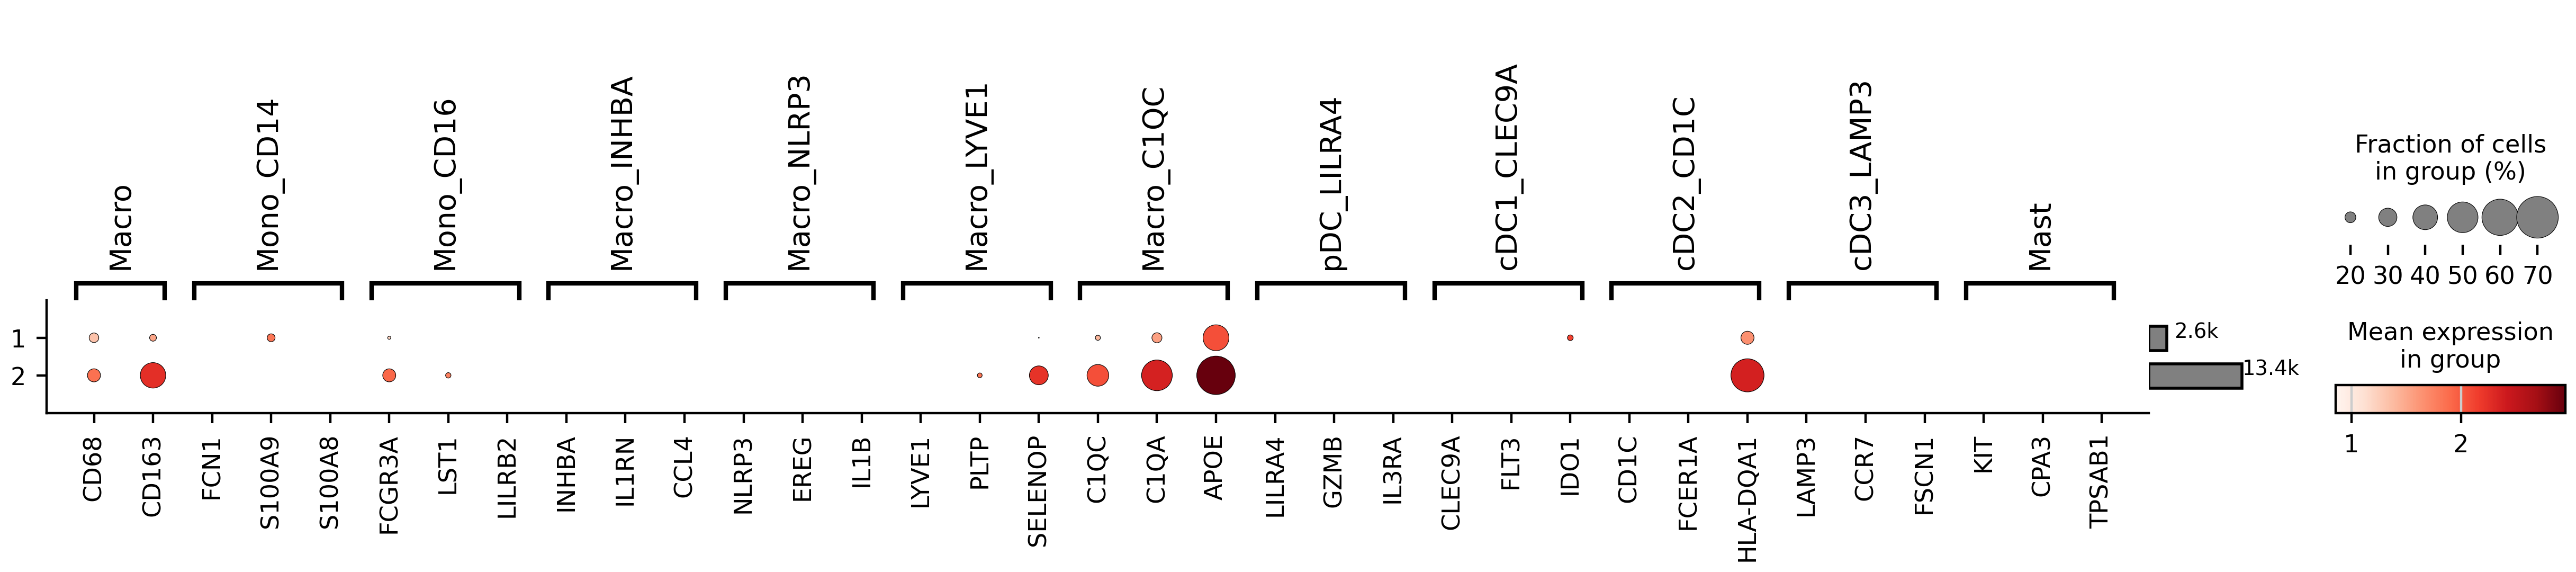

In [4]:
markers = {
    "Macro":['CD68','CD163'],
    "Mono_CD14":['FCN1','S100A9','S100A8'],
    "Mono_CD16":['FCGR3A','LST1','LILRB2'],
    "Macro_INHBA":['INHBA','IL1RN','CCL4'],
    "Macro_NLRP3":['NLRP3','EREG','IL1B'],
    "Macro_LYVE1":['LYVE1','PLTP','SELENOP'],
    "Macro_C1QC":['C1QC','C1QA','APOE'],
    "pDC_LILRA4":['LILRA4','GZMB','IL3RA'],
    "cDC1_CLEC9A":['CLEC9A','FLT3','IDO1'],
    "cDC2_CD1C":['CD1C','FCER1A','HLA-DQA1'],
    "cDC3_LAMP3":['LAMP3','CCR7','FSCN1'],
    "Mast":['KIT','CPA3','TPSAB1']
}
sc.settings.set_figure_params(dpi=200,fontsize=10)
dp=sc.pl.dotplot(
    adata,
    var_names=markers,
    groupby='scSHC',
    mean_only_expressed=True,
    return_fig=True,
)
dp.add_totals(color='gray').style(dot_edge_color='black',cmap='Reds',dot_min=.1)
dp.show()

In [5]:
adata.obs['Celltype'] = adata.obs['scSHC'].map({
    '1':'Myeloid',
    '2':'Macs'
})
adata.obs[['Celltype']].to_csv(f"{RESULT_TABLE}/annotation/Myeloid.csv")
adata.obs['Celltype'].value_counts()

Macs       13375
Myeloid     2578
Name: Celltype, dtype: int64

# Cellstates idenfification of Macs using sNMF

- see Suppl Figure4


# Load Macs cellstate annotation

In [7]:
adata = sc.read(f'{RESULT_OBJ}/gex_all.h5ad')
obs = pd.read_csv(f"{RESULT_TABLE}/MPs/Macs/Annotation.csv",index_col=0)
sample_meta = pd.read_excel(f'{RESULT_TABLE}/Supplementary Table 1.xlsx',index_col=0).replace(np.nan,'N/A')

adata = adata[adata.obs.index.isin(obs.index),:]
adata.obs['Cellstate'] = obs.loc[adata.obs.index,'Cellstate']
adata.obs = adata.obs.reset_index().merge(sample_meta,left_on='Sample',right_on='CCG_ID').set_index('index')
print(f'{adata.obs.shape[0]:,} Macrophages cells')
adata.obs['Cellstate'].value_counts()

13,375 Macrophages cells


Macs.Lipid          5291
Macs.Adhesion       2637
Macs.Endocytosis    2519
Macs.Interferon     1764
Macs.Secretion      1164
Name: Cellstate, dtype: int64

## Normalization - normalize_total

In [8]:
sc.pp.normalize_total(adata, target_sum=1e4)

# Heatmap visualization on genes in each MPs

## Load MPs geneset

In [9]:
mp_anno_path = f'{RESULT_TABLE}/MPs/Macs/MetaProgram_Annotation.csv'
mp_gmt_path = f'{RESULT_TABLE}/MPs/Macs/MP_Programs.gmt'
ref_ITH=pd.read_table(mp_gmt_path,header=None,index_col=0).drop([1],axis=1).T
anno = pd.read_csv(mp_anno_path,index_col=0)
MP_anno_map = anno[['MetaProgram','MPs']].drop_duplicates().set_index('MetaProgram')['MPs'].to_dict()
ref_ITH.columns = ref_ITH.columns.map(MP_anno_map)
ref_ITH=ref_ITH.melt()
ref_ITH.columns = ['Program','gene']
ref_ITH = ref_ITH.drop_duplicates(subset=['gene'],keep=False).set_index('gene')

## Visualize MPs in heatmap

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 26.205722222222228 mm


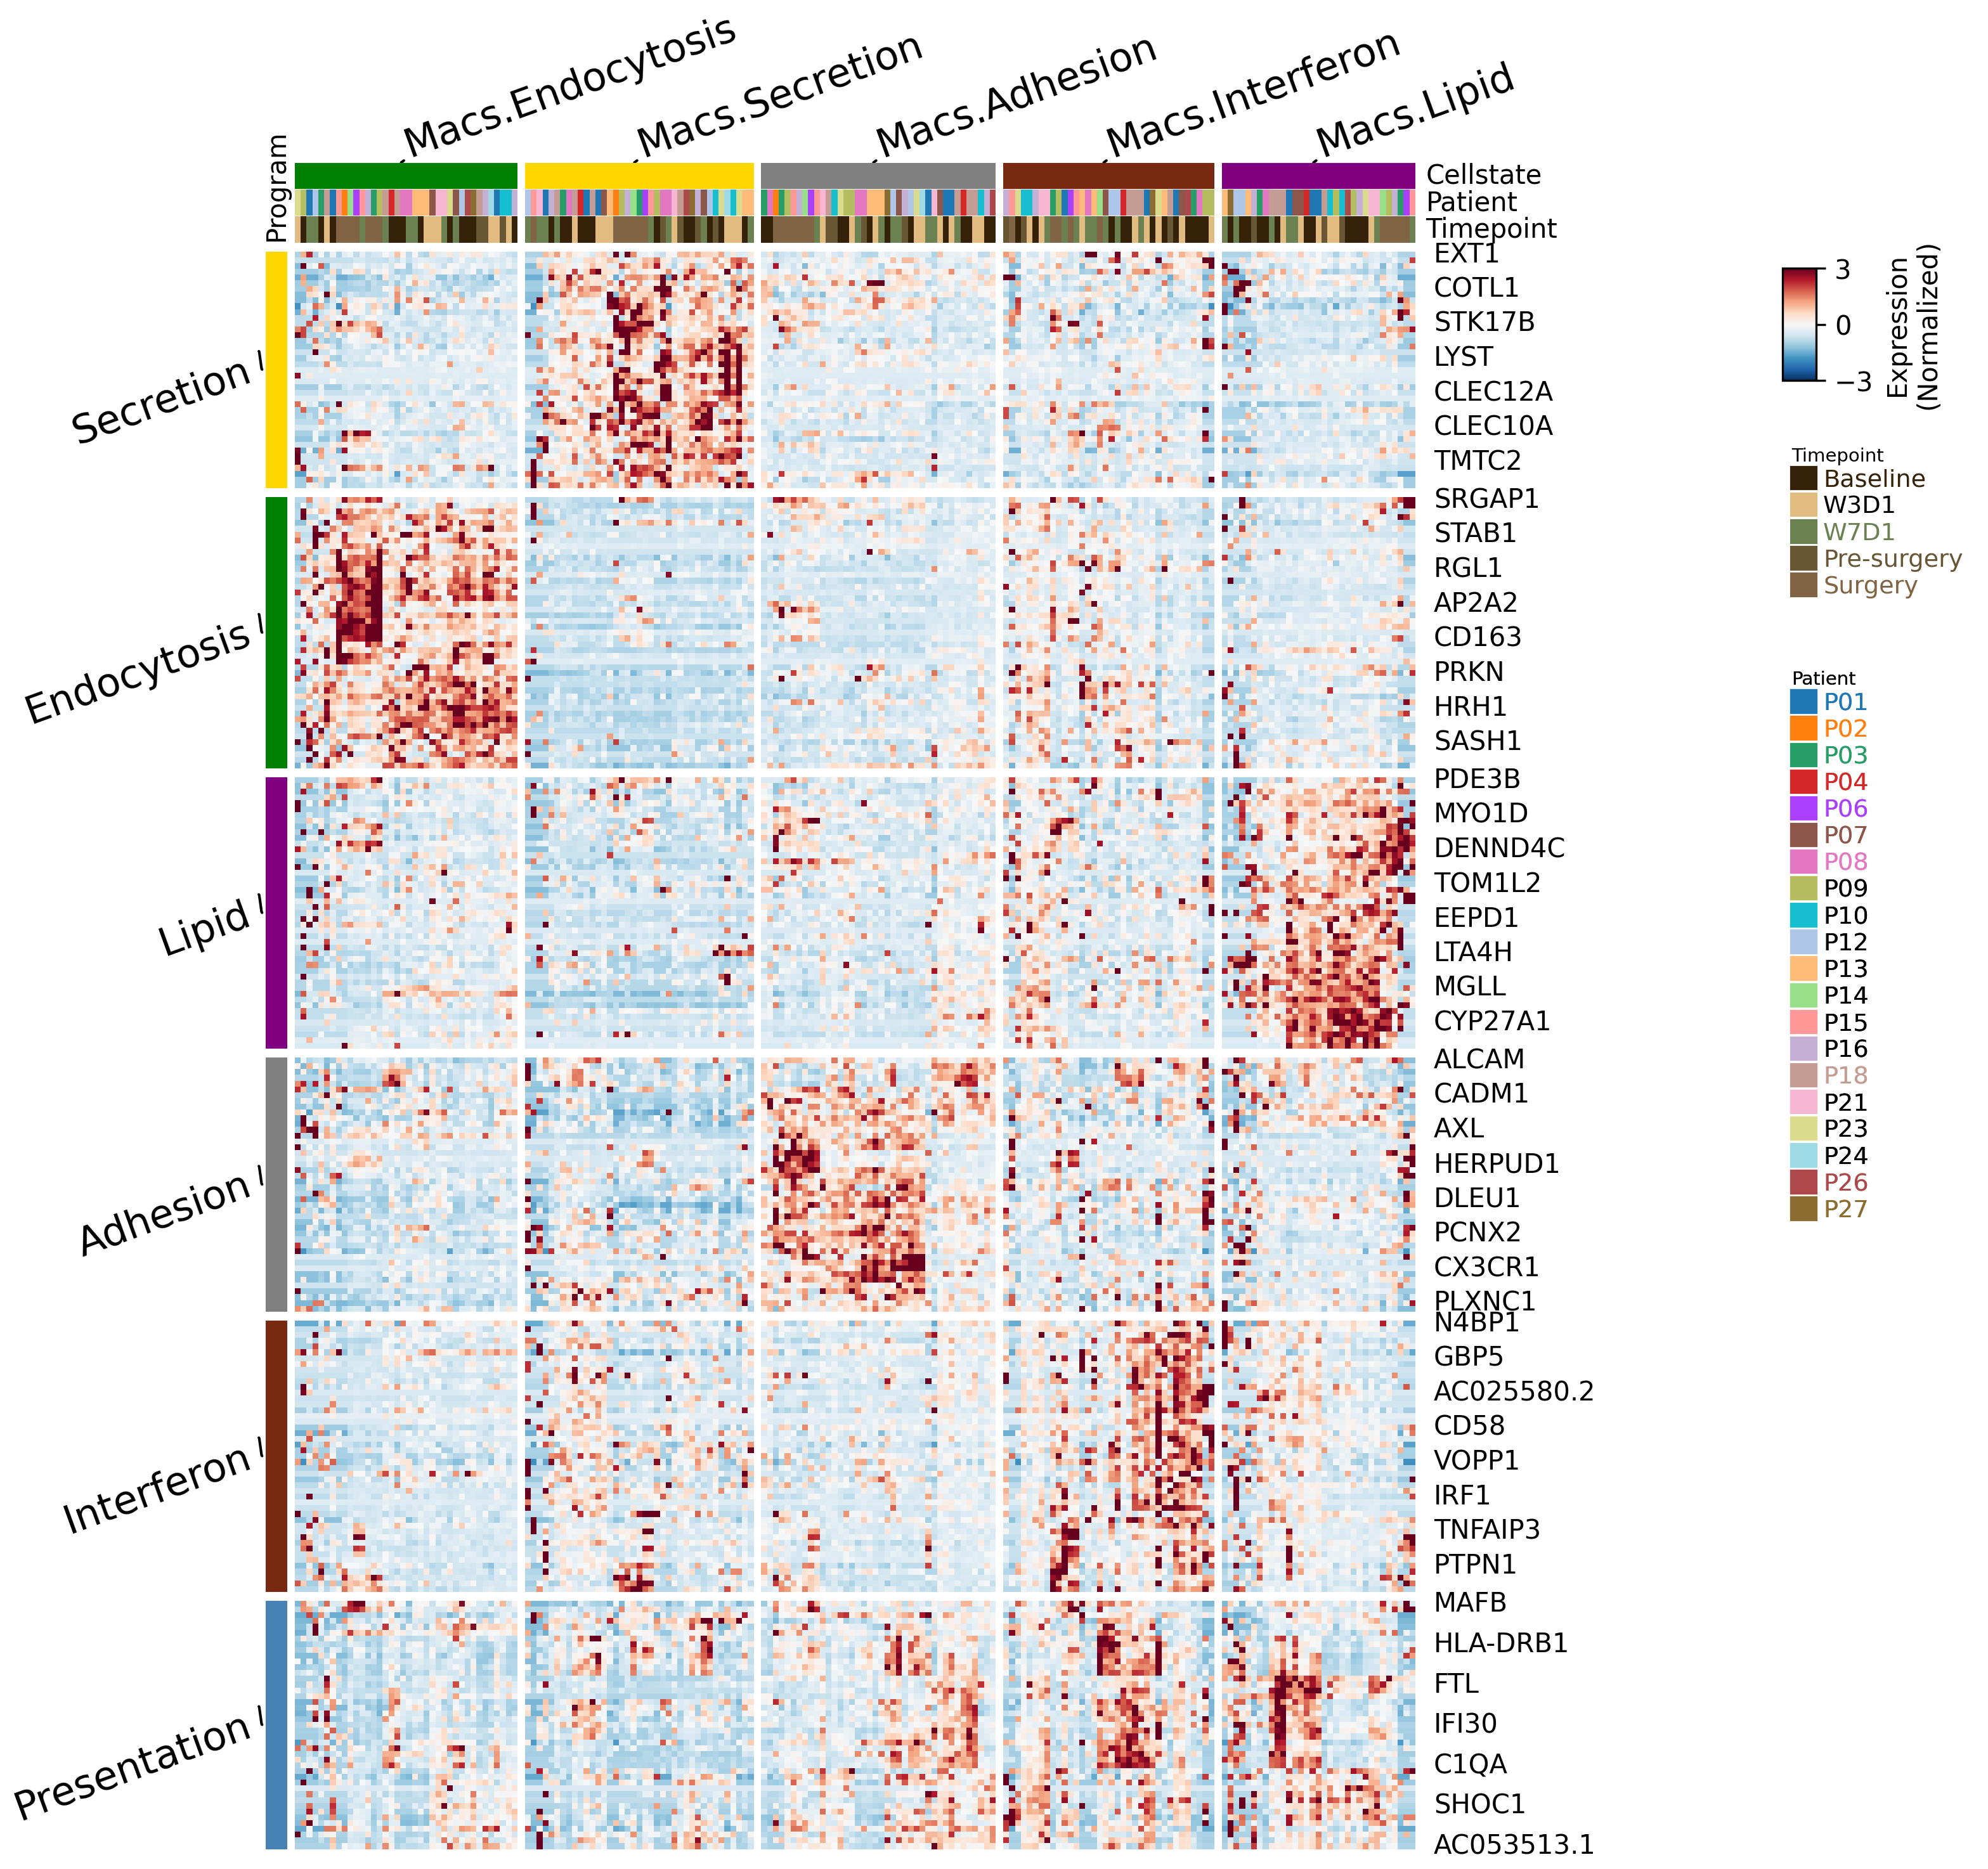

In [10]:
CELLTYPE='Macs'
palette={}
palette['Program'] = {k.replace(f'{CELLTYPE}.',''):v for k,v in COLOR_PAlETTE['Cellstate'].items() if CELLTYPE in k}
for c in ['Cellstate','Patient','Timepoint']:
    palette[c] = COLOR_PAlETTE[c]

aggregate_heatmap(adata=adata,
                  features=ref_ITH,
                  top_anno_columns=['Cellstate','Patient','Timepoint'],
                  col_split='Cellstate',
                  col_split_gap=1,
                  row_split='Program',
                  row_split_gap=1,
                  palette=palette,
                  figsize=(8,10),
                  vmin=-3,
                  vmax=3,
                  standard_normalization=True,
                  cbar_label='Expression\n(Normalized)',
                  cmap='RdBu_r'
                 )

# Score association

In [37]:
anno = pd.read_csv(f'{RESULT_TABLE}/MPs/Macs/MetaProgram_Annotation.csv',index_col=0)
MP_anno_map = anno[['MetaProgram','MPs']].drop_duplicates().set_index('MetaProgram')['MPs'].to_dict()
# get MP sores on all cells 
scores = pd.read_csv(f'{RESULT_TABLE}/MPs/Macs/signature_scores.csv',index_col=0)
# scores.columns = scores.map(MP_anno_map)
scores['CCG_ID'] =  scores.index.map(lambda x:'CCG1112'+x.split('CCG1112')[1][:-1])
# attach clinical information
sample_meta = pd.read_excel(f'{RESULT_TABLE}/Supplementary Table 1.xlsx',index_col=0).replace(np.nan,'N/A')
scores = scores.reset_index().merge(sample_meta,on='CCG_ID',how='left').set_index('index')
scores['BestResponse'] = pd.Categorical(scores.BestResponse,['favorable response\n(RCB 0-I)','unfavorable response\n(RCB II-III)'],ordered=True)

## MPs pairwise correlation

In [38]:
order = ['Endocytosis','Lipid','Secretion','Adhesion','Presentation','Interferon']
dt =  scores.rename(columns=MP_anno_map)[order].copy()
pvalues = []
for c in dt:
    p = dt.apply(lambda a: scipy.stats.pearsonr(a.values,dt[c].values)[1])
    p.name= c
    pvalues.append(p)
pvalues = pd.concat(pvalues,axis=1)
corr =  dt.corr()

In [39]:
data = corr.unstack().rename('Correlation').to_frame()
data['pvalue'] = pvalues.unstack()
data['Significance'] = 'N.S'
data.loc[data['pvalue']<0.01,'Significance'] = 'p<0.01'

data = data.reset_index().drop_duplicates(['pvalue','Correlation'])
data = data.loc[data.level_0!=data.level_1,:]

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 28.315333333333335 mm


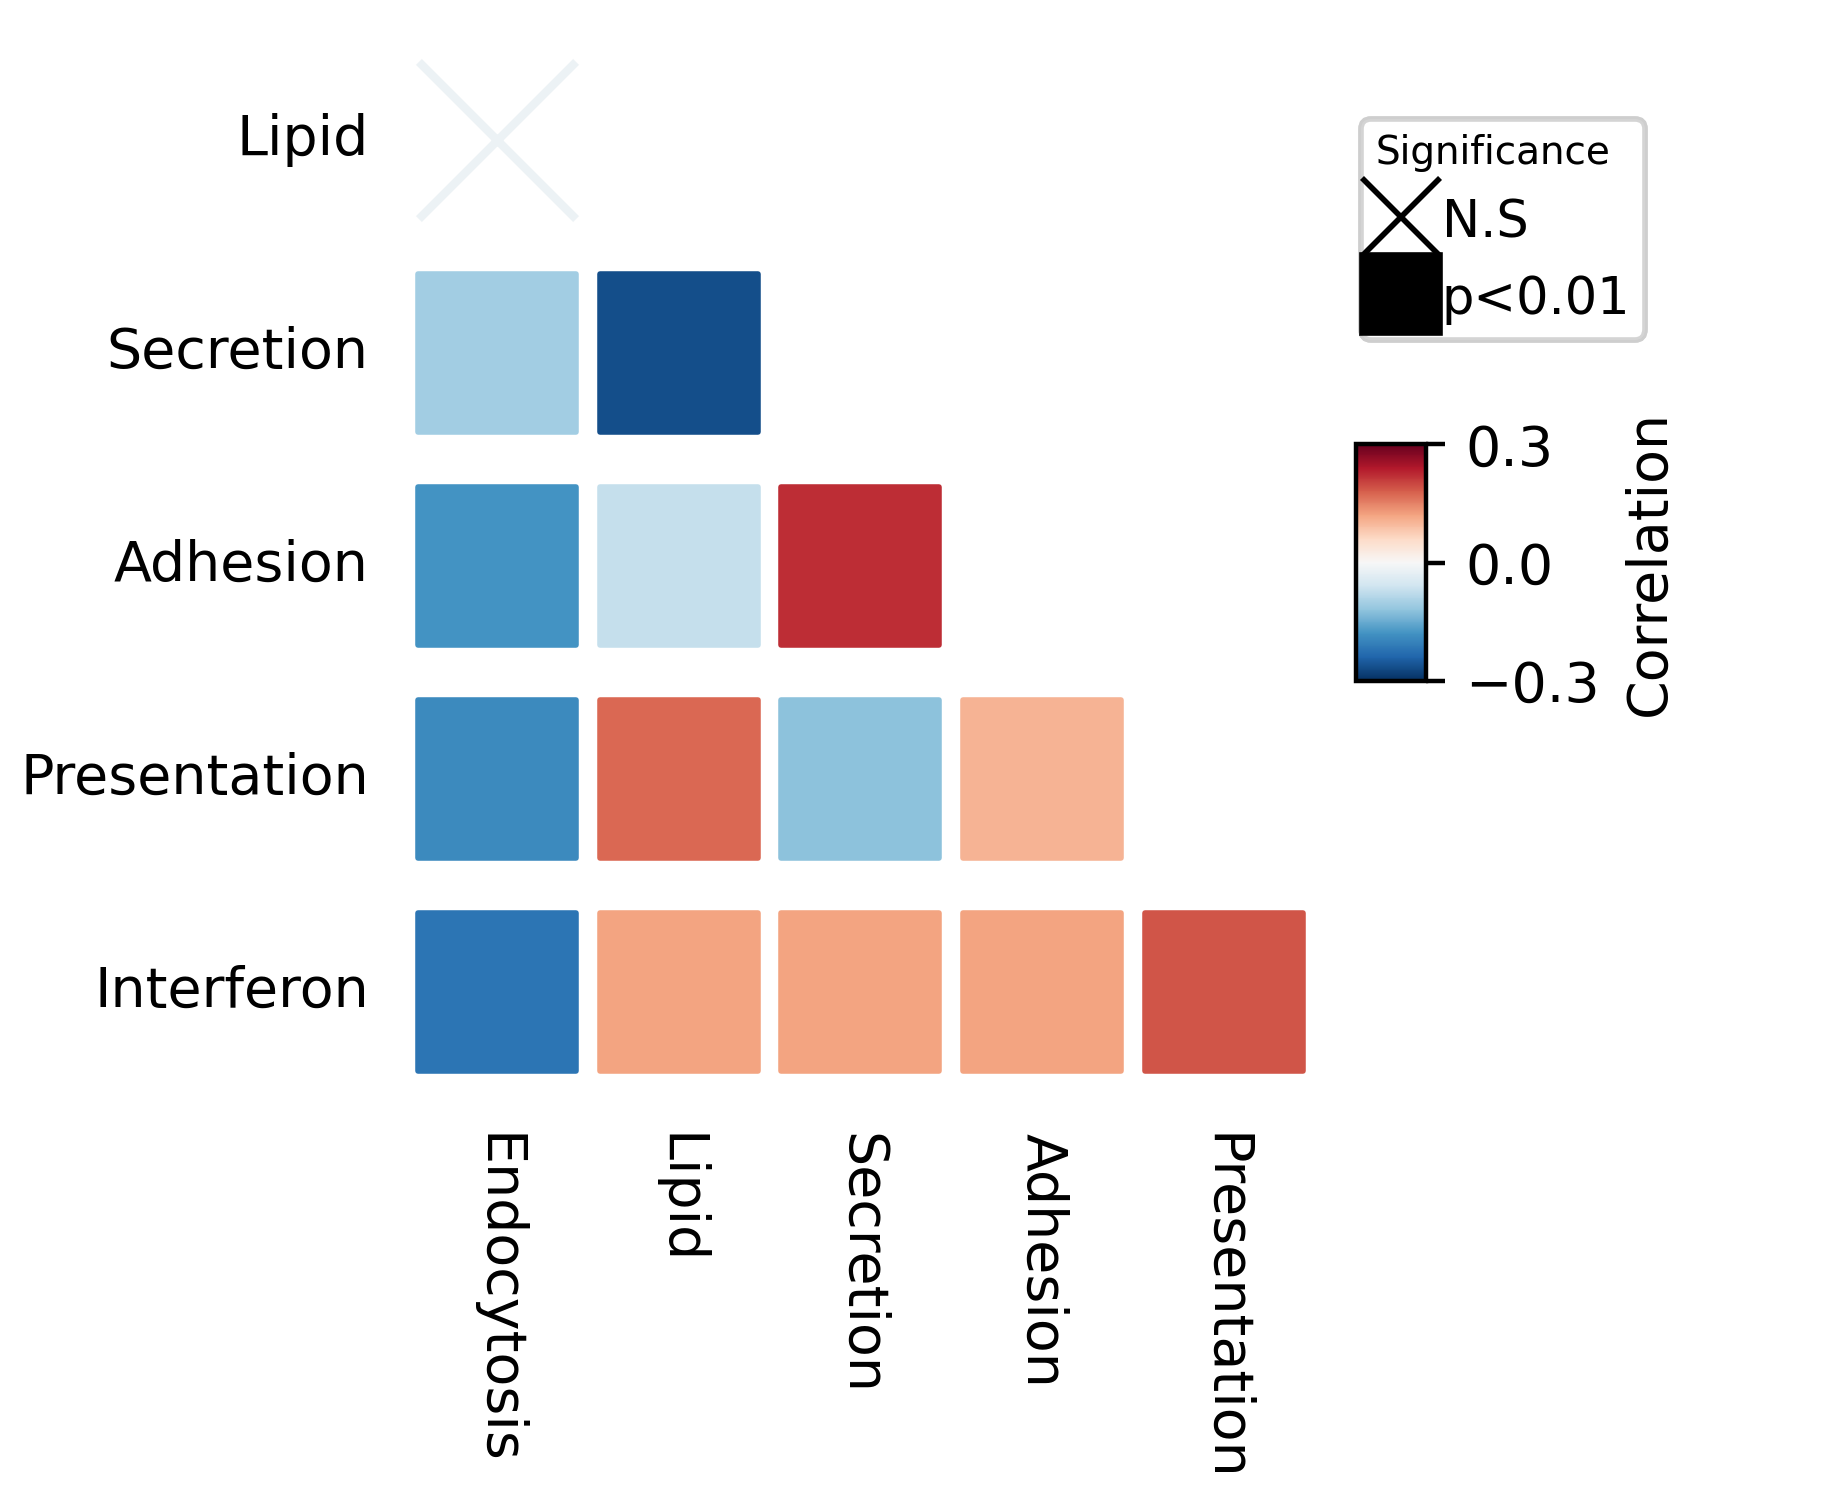

In [40]:
plt.figure(figsize=(3, 3))
plt.rcParams['axes.grid'] = False 
row_ha = HeatmapAnnotation(label=anno_label(pd.Series(order,index=order),colors='k'),axis=0)
col_ha = HeatmapAnnotation(label=anno_label(pd.Series(order,index=order),colors='k'),axis=1)
# col_ha = HeatmapAnnotation(label=anno_label(pd.Series(['Endocytosis','Lipid','Presentation','Interferon','Adhesion','Secretion'])))
cm = DotClustermapPlotter(data=data, x='level_0',y='level_1',value='Correlation',c='Correlation',hue='Significance',
                          s=4,
                          # top_annotation=col_ha,
                          # left_annotation=row_ha,
                          col_split=pd.Series(order[:-1],index=order[:-1]),
                          col_split_order = order[:-1],
                          row_split=pd.Series(order[1:],index=order[1:]),
                          row_split_order = order[1:],
                          marker={'N.S':'x','p<0.01':'s'},
                          vmax=.3,vmin=-.3,cmap='RdBu_r',
                          ratio=200,
                          row_cluster=False,col_cluster=False,
                          show_rownames=True,show_colnames=True,row_names_side='left')
plt.show()

<Axes: >

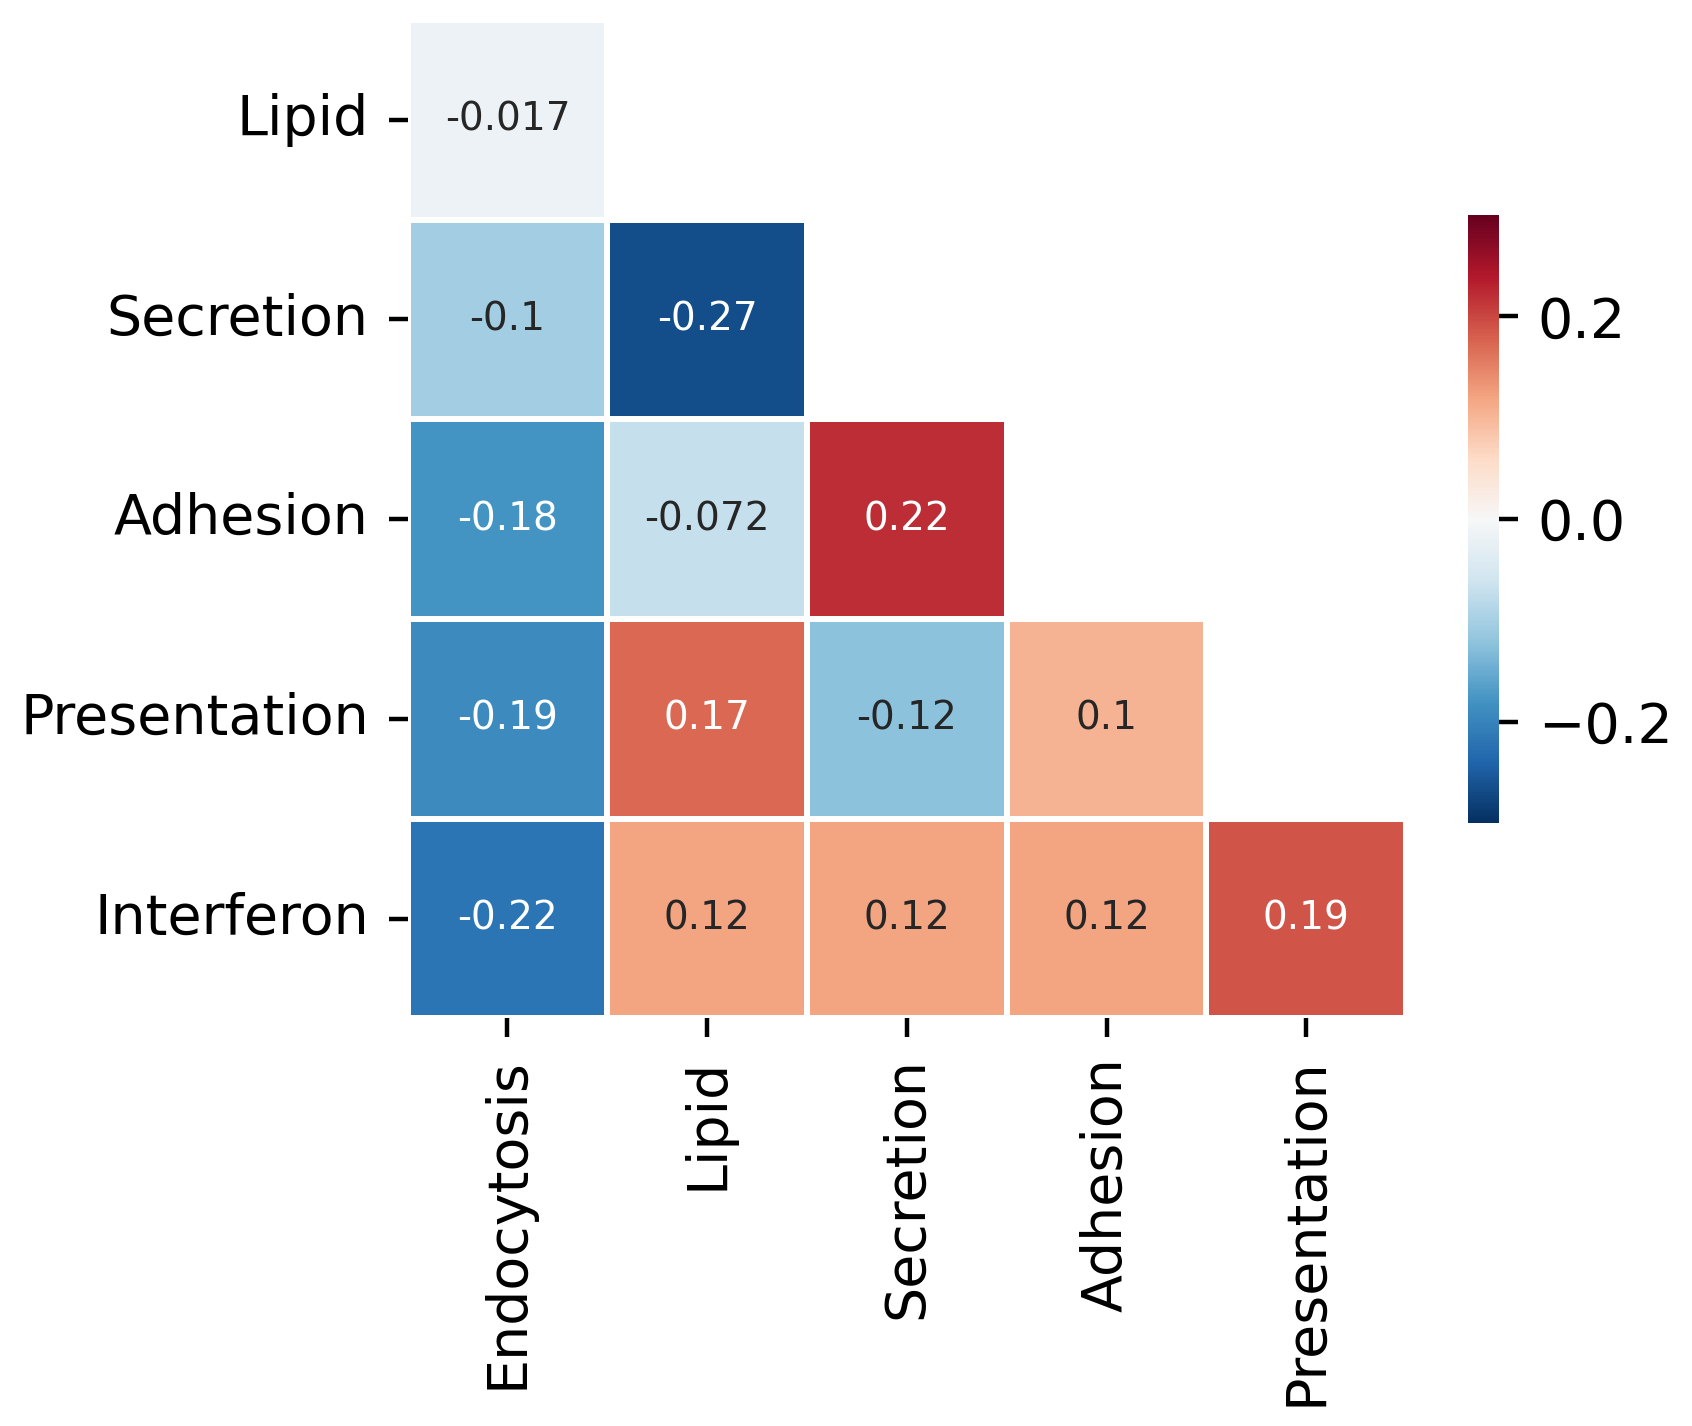

In [41]:
mask = np.triu(corr.iloc[1:,:-1],1)
sns.heatmap(corr.iloc[1:,:-1],
            square=True,cmap='RdBu_r',vmax=.3,vmin=-.3,mask=mask,
            linewidths=1, cbar_kws={"shrink": .5},annot=True)

## Correaltion with external Score M1/M2

### Signature score calculation

In [22]:
ext_sig_gmt_path = f"{EXTERNAL_DATA}/Combined_Jablonski_Alt_Class_Mac.gmt.txt"
# To note, the adata has been normalized before.
ext_scores = sp.ext.VISION(data=adata,gmt_files=[ext_sig_gmt_path],outdir='.')

Rscript /home/analysis/scPipe/scPipe/Rscripts/VISION.R --gmt_files ..//data/external/Combined_Jablonski_Alt_Class_Mac.gmt.txt --h5ad /tmp/tmpep0tisj2/count.h5ad --output_file /tmp/tmpep0tisj2/vision.tsv
$gmt_files
[1] "..//data/external/Combined_Jablonski_Alt_Class_Mac.gmt.txt"

$h5ad
[1] "/tmp/tmpep0tisj2/count.h5ad"

$output_file
[1] "/tmp/tmpep0tisj2/vision.tsv"



Loading data from ..//data/external/Combined_Jablonski_Alt_Class_Mac.gmt.txt ...

Using 21898/36601 genes detected in 0.10% of cells for signature analysis.
See the `sig_gene_threshold` input to change this behavior.

Evaluating signature scores on cells...

'as(<matrix>, "dgeMatrix")' is deprecated.
Use 'as(as(as(., "dMatrix"), "generalMatrix"), "unpackedMatrix")' instead.
See help("Deprecated") and help("Matrix-deprecated").
Evaluating signature-gene importance...

Warning messages:
1: In asMethod(object) :
  sparse->dense coercion: allocating vector of size 3.6 GiB
2: In asMethod(object) :
  sparse->dense coercion: allocating vector of size 3.6 GiB


In [24]:
Ext_Score_Map = {
    'AltActivated_IL4__Jablonski':'M2_Jablonski',
    'ClassicallyActivated_LPSIFNy_Jablonski':'M1_Jablonski',
    'Becker_M_IFNyLPSTNFa':'M1_Becker',
    'Becker_M_IL4IL13':'M2_Becker',
    'Guerriero_M1':'M1_Guerriero',
    'Guerriero_M2':'M2_Guerriero',
}
ext_scores.rename(columns=Ext_Score_Map,inplace=True)
ext_scores.to_csv(f'{RESULT_TABLE}/MPs/Macs/ext_M1M2_signature_scores.csv')

In [42]:
order = ['Endocytosis','Lipid','Presentation','Adhesion','Secretion','Interferon']
dt =  scores.rename(columns=MP_anno_map)[order].merge(ext_scores,left_index=True,right_index=True)
pvalues = []
for c in dt:
    p = dt.apply(lambda a: scipy.stats.pearsonr(a.values,dt[c].values)[1])
    p.name= c
    pvalues.append(p)
pvalues = pd.concat(pvalues,axis=1)
corr =  dt.corr()

data = corr.unstack().rename('Correlation').to_frame()
data['pvalue'] = pvalues.unstack()
data['Significance'] = 'N.S'
data.loc[data['pvalue']<0.01,'Significance'] = 'p<0.01'

data = data.reset_index()
data = data.loc[(data.level_0.isin(list(Ext_Score_Map.values())))&
                (~data.level_1.isin(list(Ext_Score_Map.values()))),:]

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 28.315333333333335 mm


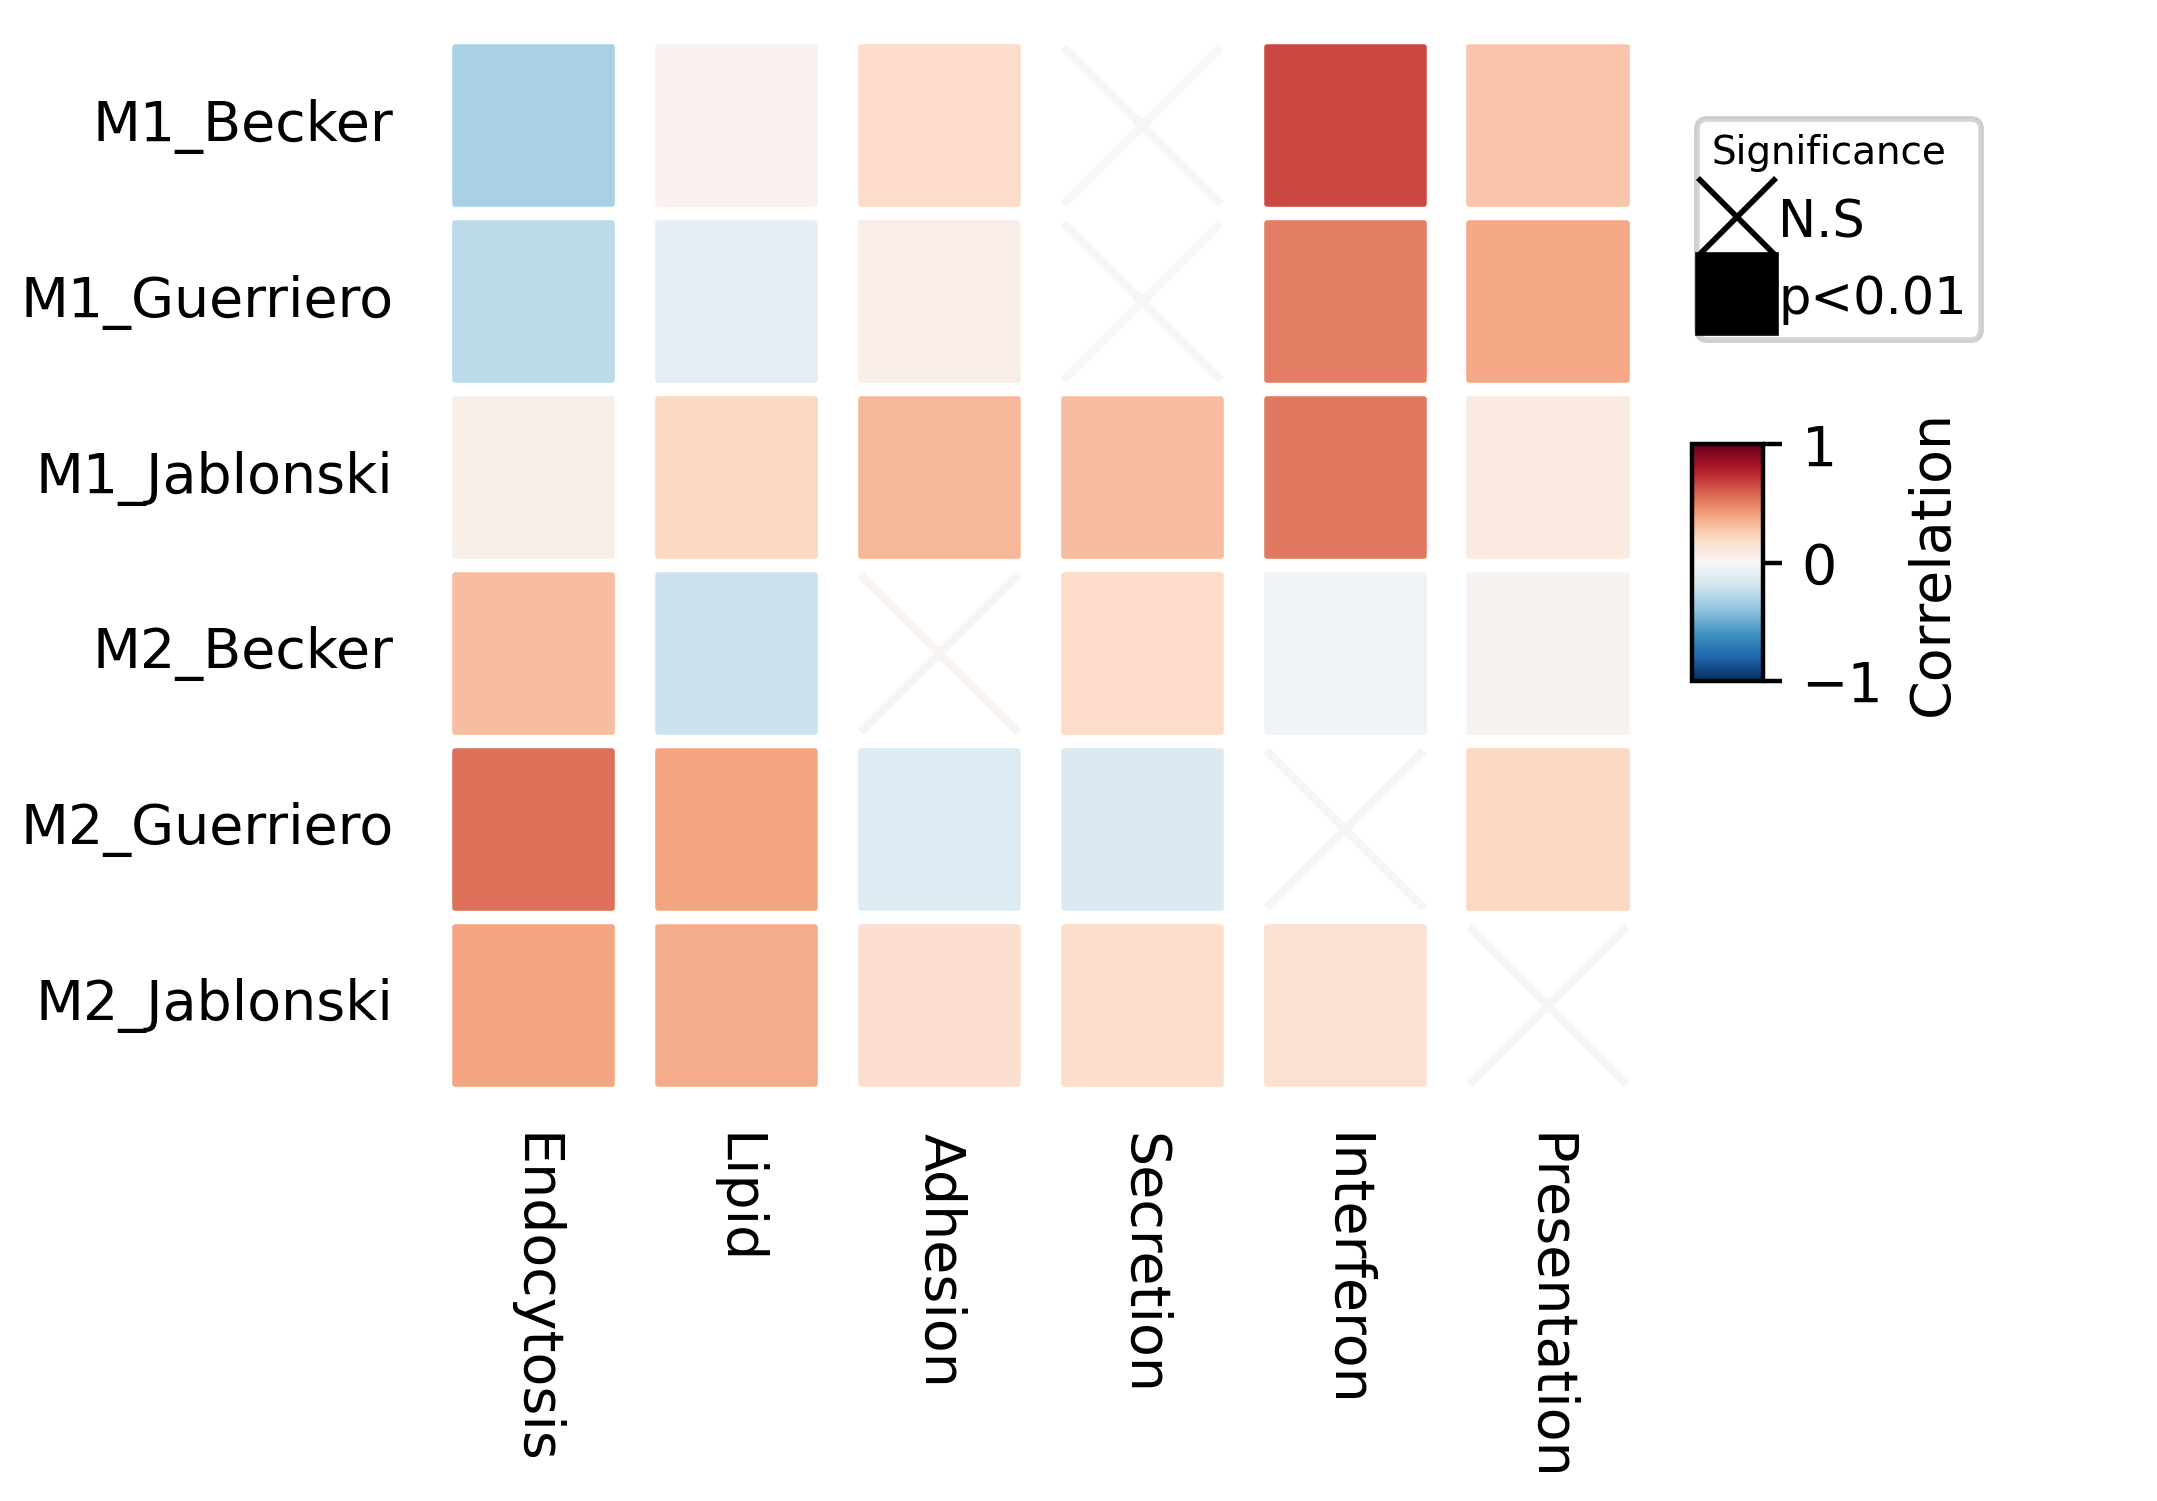

In [44]:
plt.figure(figsize=(4, 3))
plt.rcParams['axes.grid'] = False 
# col_ha = HeatmapAnnotation(label=anno_label(pd.Series(['Endocytosis','Lipid','Presentation','Interferon','Adhesion','Secretion'])))
cm = DotClustermapPlotter(data=data, x='level_1',y='level_0',value='Correlation',c='Correlation',hue='Significance',
                          s=4,
                          # top_annotation=col_ha,
                          # left_annotation=row_ha,
                          # col_split=pd.Series(order[:-1],index=order[:-1]),
                          # col_split_order = order[:-1],
                          # row_split=pd.Series(order[1:],index=order[1:]),
                          # row_split_order = order[1:],
                          marker={'N.S':'x','p<0.01':'s'},
                          vmax=1,vmin=-1,cmap='RdBu_r',
                          ratio=200,
                          row_cluster=False,col_cluster=True,
                          show_rownames=True,show_colnames=True,row_names_side='left')
plt.show()

## Prediction power
### Baseline

In [45]:
x='BestResponse'
timepoints =['Baseline']
explored_z=None
random_var='Patient'
x_order=['favorable response\n(RCB 0-I)','unfavorable response\n(RCB II-III)']
dt = scores.loc[(scores.Timepoint.isin(timepoints)),:].copy()
dt[x] = pd.Categorical(dt[x],x_order,ordered=True)
output_table = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[],explored_z=explored_z,random_var=random_var).replace(MP_anno_map)
output_table.to_csv(f'{RESULT_TABLE}/LmTest/Macs_Baseline_Prediction.csv',index=False)
pvalues = output_table.set_index(['Y'])['Pvalue']
output_table

,Ctrl,Experiment,Y,Coef,log2FC,Pvalue,FDR
0,favorable response\n(RCB 0-I),unfavorable response\n(RCB II-III),Interferon,-0.337669,-0.385920,0.11706997547094501,0.351210
0,favorable response\n(RCB 0-I),unfavorable response\n(RCB II-III),Endocytosis,-0.260929,-0.238241,0.4869779682814622,0.870828
0,favorable response\n(RCB 0-I),unfavorable response\n(RCB II-III),Presentation,-0.151111,-0.103110,0.7256895838264705,0.870828
0,favorable response\n(RCB 0-I),unfavorable response\n(RCB II-III),Secretion,0.012507,0.012833,0.9539976946947053,0.953998
0,favorable response\n(RCB 0-I),unfavorable response\n(RCB II-III),Adhesion,0.208680,0.161566,0.11285184005853974,0.351210
0,favorable response\n(RCB 0-I),unfavorable response\n(RCB II-III),Lipid,0.162073,0.192669,0.6814857020950063,0.870828


### Distribution of MPs between two RCB groups

Text(0.5, 1.02, 'Macrophage cells from baseline samples.')

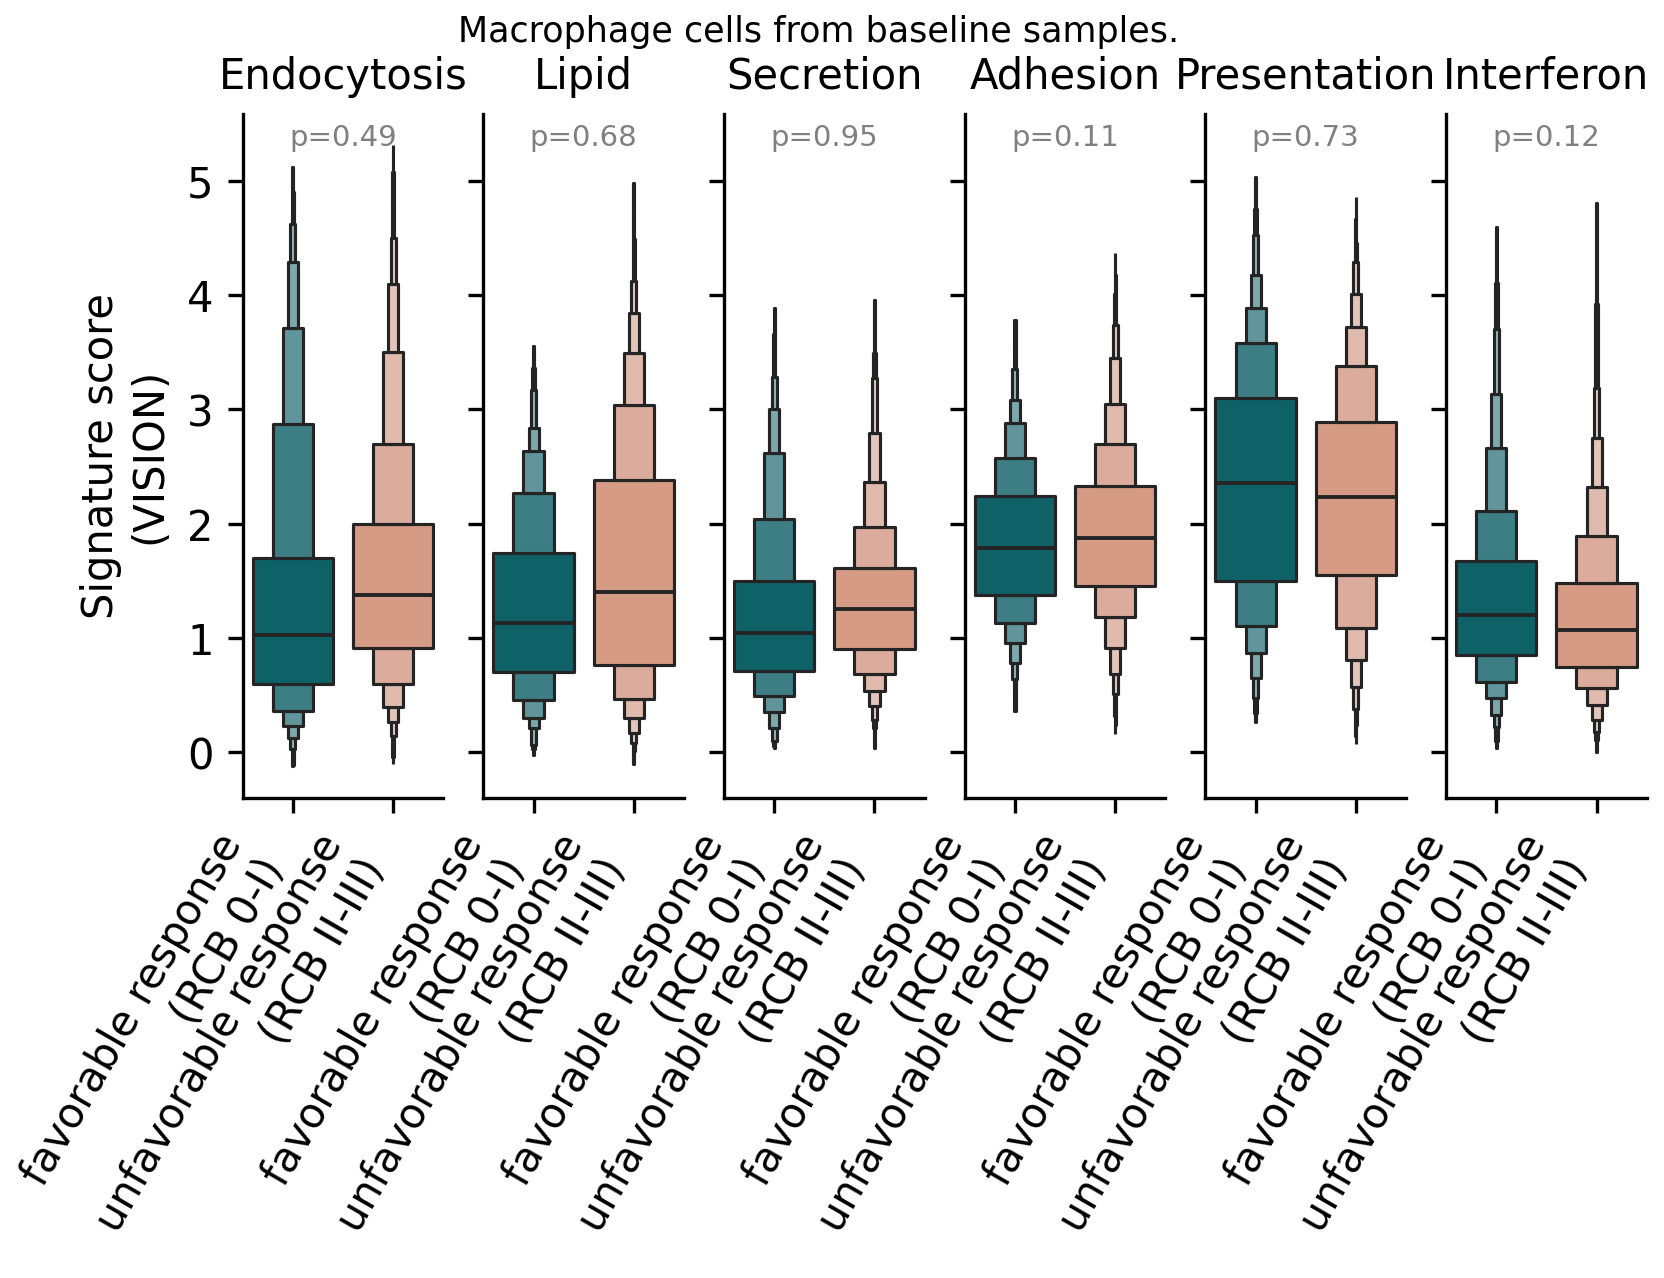

In [22]:
show_mps =  ['Endocytosis','Lipid','Secretion','Adhesion','Presentation','Interferon']
plt_dt = dt.rename(columns=MP_anno_map)
fig,axs=plt.subplots(1,len(show_mps),dpi=150,sharey=True,figsize=(6,3))
for i,subtype in enumerate(show_mps):
    ax=axs[i]
    sns.boxenplot(data=plt_dt,
                  ax=ax,x=x,y=subtype,hue=x,
                  showfliers=False,
                  palette=COLOR_PAlETTE[x])
    # ax.legend_.remove()
    ax.set(xlabel='',title=subtype,ylabel='Signature score\n(VISION)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right',va='top')
    y_loc =5.5
    pvalue = pvalues[subtype]
    if pvalue >= 0.05:
        c='gray'
        label = f"p={pvalue:.2f}"
    else:
        label = f"p={pvalue:.3f}"
        c = 'red'
    ax.text(.5,y_loc,s=label,ha='center',va='top',color=c,fontsize=7)
plt.suptitle('Macrophage cells from baseline samples.',y=1.02)

### W3D1

In [23]:
x='BestResponse'
timepoints =['W3D1']
explored_z=None
random_var='Patient'
x_order=['favorable response\n(RCB 0-I)','unfavorable response\n(RCB II-III)']
dt = scores.loc[(scores.Timepoint.isin(timepoints)),:].copy()
dt[x] = pd.Categorical(dt[x],x_order,ordered=True)
output_table = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[],explored_z=explored_z,random_var=random_var).replace(MP_anno_map)
output_table.to_csv(f'{RESULT_TABLE}/LmTest/Macs_W3D1_Prediction.csv',index=False)
pvalues = output_table.set_index(['Y'])['Pvalue']
output_table

,Ctrl,Experiment,Y,Coef,log2FC,Pvalue,FDR
0,favorable response\n(RCB 0-I),unfavorable response\n(RCB II-III),Interferon,-0.694551,-0.746749,2.4025647622069175e-10,1.441539e-09
0,favorable response\n(RCB 0-I),unfavorable response\n(RCB II-III),Presentation,-0.758005,-0.418593,0.09666201380744124,1.899981e-01
0,favorable response\n(RCB 0-I),unfavorable response\n(RCB II-III),Lipid,-0.334660,-0.357544,0.44641346910698665,4.464135e-01
0,favorable response\n(RCB 0-I),unfavorable response\n(RCB II-III),Secretion,0.342846,0.376491,0.12666543315769316,1.899981e-01
0,favorable response\n(RCB 0-I),unfavorable response\n(RCB II-III),Adhesion,0.733965,0.524527,0.12028417416318306,1.899981e-01
0,favorable response\n(RCB 0-I),unfavorable response\n(RCB II-III),Endocytosis,0.536440,0.547531,0.31061974097344075,3.727437e-01


### Distribution of MPs between two RCB groups

Text(0.5, 1.02, 'Macrophage cells from on-monotherapy samples')

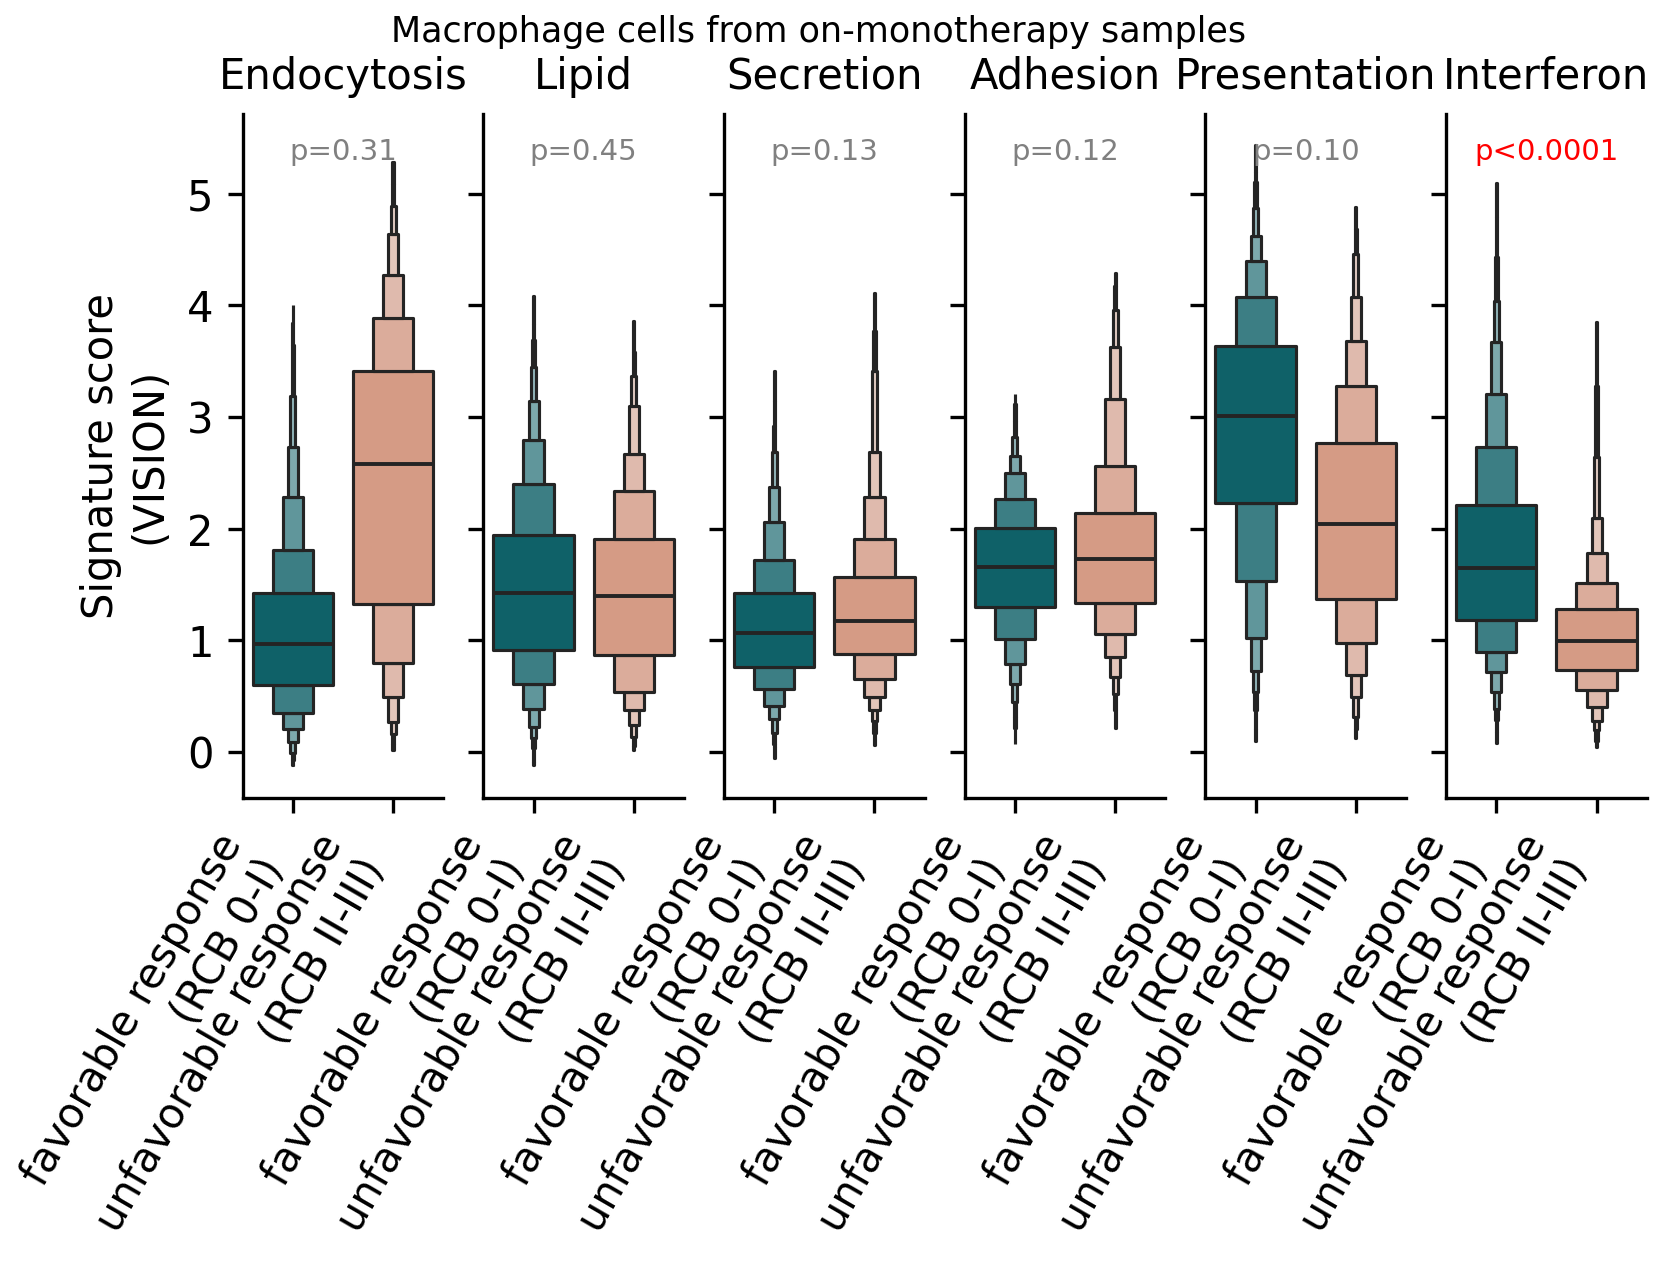

In [24]:
show_mps =  ['Endocytosis','Lipid','Secretion','Adhesion','Presentation','Interferon']
plt_dt = dt.rename(columns=MP_anno_map)
fig,axs=plt.subplots(1,len(show_mps),dpi=150,sharey=True,figsize=(6,3))
for i,subtype in enumerate(show_mps):
    ax=axs[i]
    sns.boxenplot(data=plt_dt,
                  ax=ax,x=x,y=subtype,hue=x,
                  showfliers=False,
                  palette=COLOR_PAlETTE[x])
    # ax.legend_.remove()
    ax.set(xlabel='',title=subtype,ylabel='Signature score\n(VISION)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right',va='top')
    y_loc =5.5
    pvalue = pvalues[subtype]
    if pvalue >= 0.05:
        c='gray'
        label = f"p={pvalue:.2f}"
    elif pvalue >= 0.0001:
        label = f"p={pvalue:.3f}"
        c = 'red'
    else:
        label = f"p<0.0001"
        c = 'red'

    ax.text(.5,y_loc,s=label,ha='center',va='top',color=c,fontsize=7)
plt.suptitle('Macrophage cells from on-monotherapy samples',y=1.02)

# Treatment-induced program shifts

## Monotherapy
### Chemotherapy induced MPs shift

In [25]:
tx_arm = 'Chemo->Combo'
x='Timepoint'
explored_z='BestResponse'
random_var='Patient'
dt = scores.loc[(scores.Timepoint.isin(['Baseline','W3D1']))&
                (scores.Treatment_Arm==tx_arm),:].copy()
## subsets pts with samples biopsied at both timepoint
paired_pts = dt[['Timepoint',random_var]].drop_duplicates()[random_var].value_counts()
paired_pts = paired_pts[paired_pts>1].index
dt= dt.loc[dt[random_var].isin(paired_pts),:]
## perform linear mixture model test
dt[x] = pd.Categorical(dt[x],['Baseline','W3D1'],ordered=True)
print(dt.groupby(explored_z)[random_var].nunique())
result = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[],explored_z=explored_z,random_var=random_var)
result.Y =  result.Y.map(MP_anno_map)
result

BestResponse
favorable response\n(RCB 0-I)         1
unfavorable response\n(RCB II-III)    1
Name: Patient, dtype: int64


,Ctrl,Experiment,Y,Coef,log2FC,Pvalue,BestResponse,FDR
0,Baseline,W3D1,Lipid,0.060296,-0.019388,0.11724869657883565,favorable response\n(RCB 0-I)+unfavorable resp...,0.117249
0,Baseline,W3D1,Presentation,0.459968,0.020793,1.9643573156649816e-25,favorable response\n(RCB 0-I)+unfavorable resp...,0.0
0,Baseline,W3D1,Endocytosis,0.290152,0.037752,2.813454576218286e-13,favorable response\n(RCB 0-I)+unfavorable resp...,0.0
0,Baseline,W3D1,Adhesion,0.860129,0.039188,9.74056909531763e-11,unfavorable response\n(RCB II-III),0.0
0,Baseline,W3D1,Adhesion,-0.047032,0.039188,0.12488827566344311,favorable response\n(RCB 0-I),0.124888
0,Baseline,W3D1,Lipid,0.087398,0.085525,0.044197009045760516,favorable response\n(RCB 0-I),0.053036
0,Baseline,W3D1,Lipid,-0.118304,0.085525,0.05179364734990565,unfavorable response\n(RCB II-III),0.051794
0,Baseline,W3D1,Interferon,0.387228,0.135725,1.323963782479462e-27,favorable response\n(RCB 0-I)+unfavorable resp...,0.0
0,Baseline,W3D1,Presentation,-0.547725,0.261146,2.782917548831889e-09,unfavorable response\n(RCB II-III),0.0
0,Baseline,W3D1,Presentation,0.612887,0.261146,8.05706849858789e-38,favorable response\n(RCB 0-I),0.0


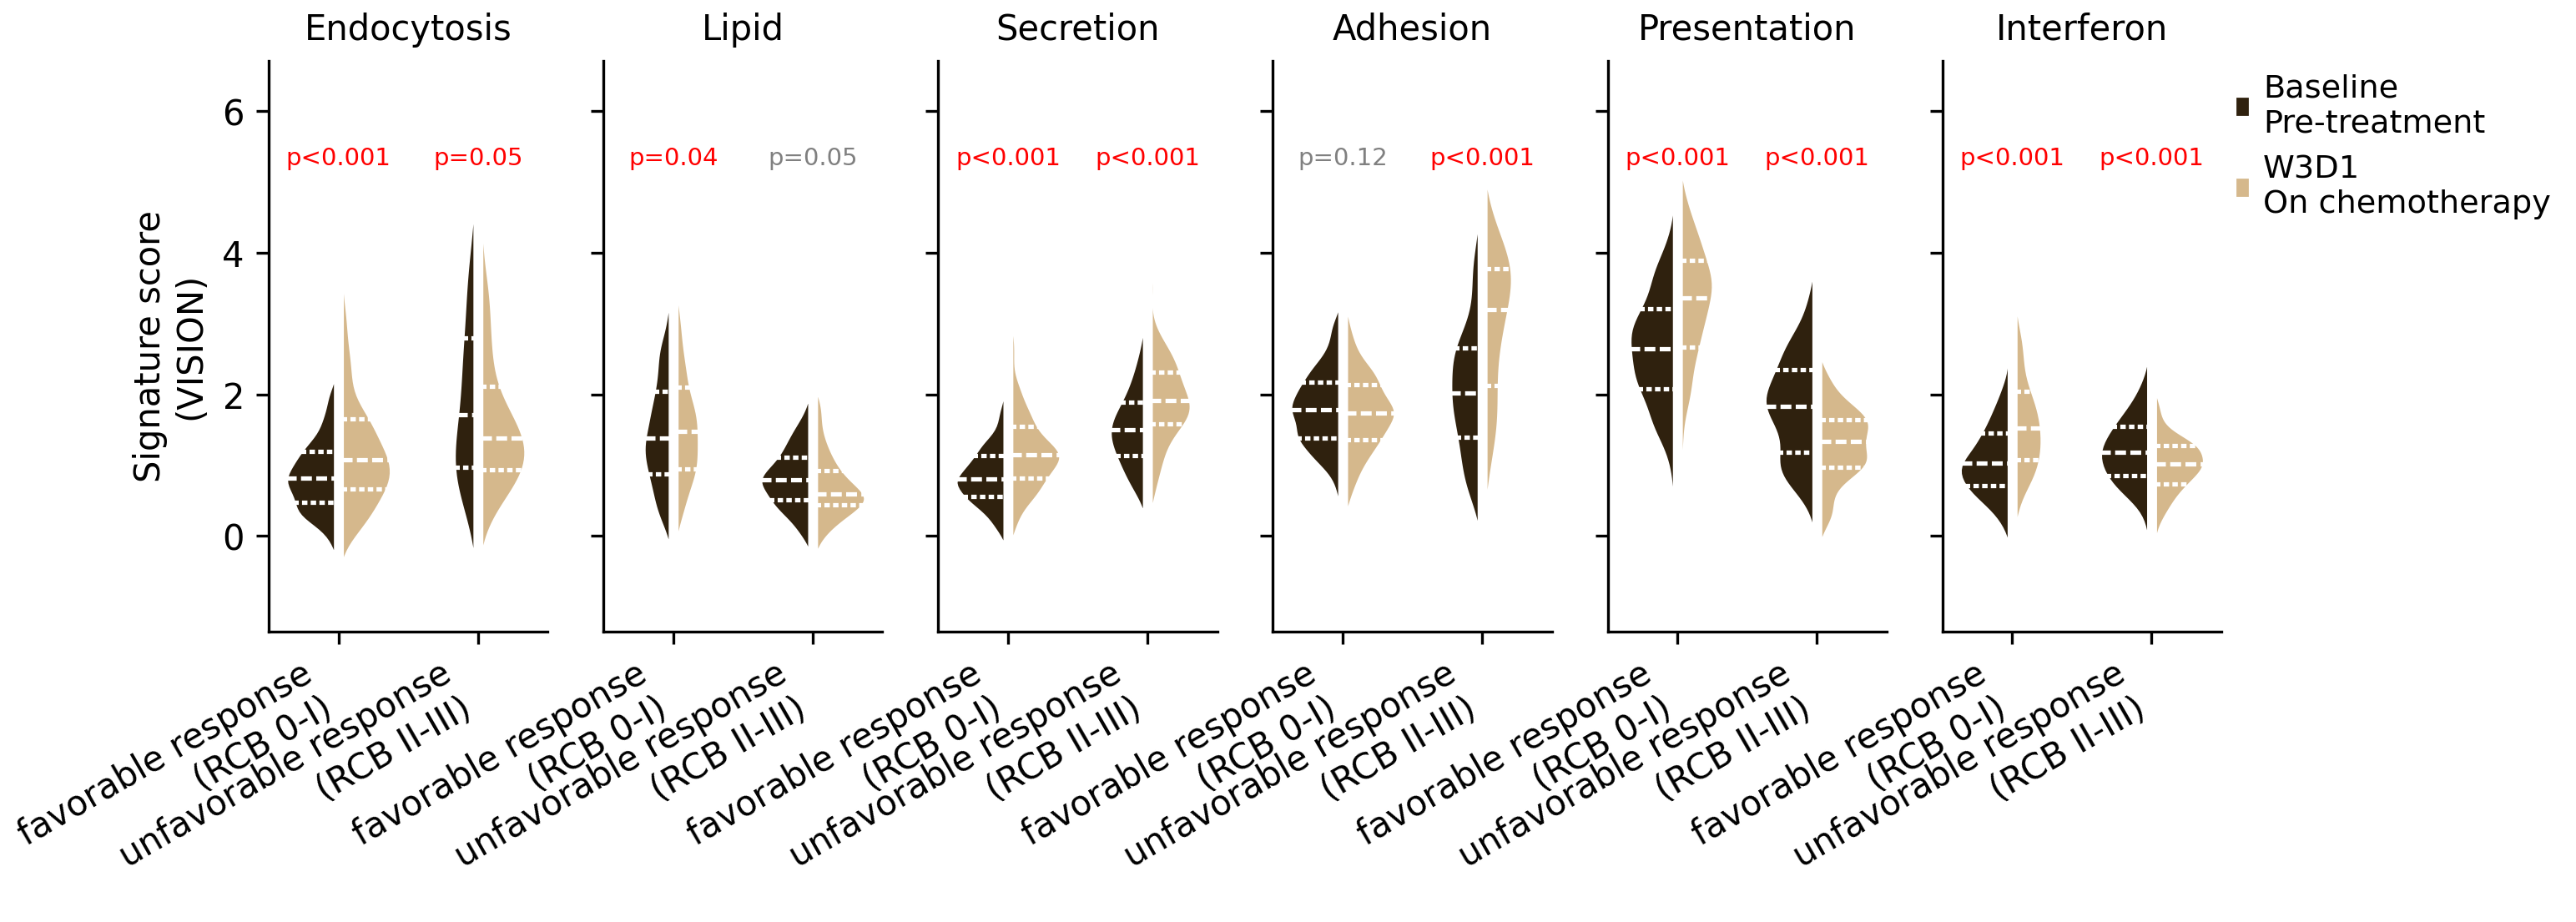

In [26]:
pvalues = result.set_index(['Y',explored_z])['Pvalue']
plt_dt = dt.rename(columns=MP_anno_map)
fig,axs=plt.subplots(1,6,dpi=150,sharey=True,figsize=(10,3))
for i,subtype in enumerate(show_mps):
    ax=axs[i]
    sns.violinplot(data=plt_dt,
                  x='BestResponse',y=subtype,hue='Timepoint',
                  ax=ax,
                  split=True, gap=.1, inner="quart",linecolor='white',
                  palette=COLOR_PAlETTE['Timepoint'])

    ## Add pvalue
    y_loc =5.5
    for xtick in ax.get_xticklabels():
        x_loc,_ = xtick.get_position()
        text = xtick.get_text()
        if pvalues[subtype,text] >= 0.05:
            c='gray'
            label = f"p={pvalues[subtype,text]:.2f}"
        elif pvalues[subtype,text] >= 0.01:
            label = f"p={pvalues[subtype,text]:.2f}"
            c = 'red'
        elif pvalues[subtype,text] >= 0.001:
            label = f"p={pvalues[subtype,text]:.3f}"
            c = 'red'
        else:
            label = "p<0.001"
            c = 'red'
        ax.text(x_loc,y_loc,s=label,ha='center',va='top',color=c,fontsize=7)
    ### rename legend label
    if i !=5:
        ax.legend_.remove()
    else:
        handles, previous_labels = ax.get_legend_handles_labels()
        new_labels = [ {'Baseline':'Baseline\nPre-treatment',
                        'W3D1':'W3D1\nOn chemotherapy'}[text]for text in previous_labels]
        ax.legend(loc=(1,.7),handles=handles, labels=new_labels)
    ax.set(xlabel='',title=subtype,ylabel='Signature score\n(VISION)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

### Pembro induced MPs shifts

In [27]:
tx_arm = 'ICI->Combo'
x='Timepoint'
explored_z='BestResponse'
random_var='Patient'
dt = scores.loc[(scores.Timepoint.isin(['Baseline','W3D1']))&
                (scores.Treatment_Arm==tx_arm),:].copy()
## subsets pts with samples biopsied at both timepoint
paired_pts = dt[['Timepoint',random_var]].drop_duplicates()[random_var].value_counts()
paired_pts = paired_pts[paired_pts>1].index
dt= dt.loc[dt[random_var].isin(paired_pts),:]
## perform linear mixture model test
dt[x] = pd.Categorical(dt[x],['Baseline','W3D1'],ordered=True)
print(dt.groupby(explored_z)[random_var].nunique())
dt[explored_z] = dt[explored_z].astype(str)
result = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[],explored_z=explored_z,random_var=random_var).drop_duplicates(['Y',explored_z])
result.Y =  result.Y.map(MP_anno_map)
result

BestResponse
favorable response\n(RCB 0-I)         0
unfavorable response\n(RCB II-III)    3
Name: Patient, dtype: int64


,Ctrl,Experiment,Y,Coef,log2FC,Pvalue,BestResponse,FDR
0,Baseline,W3D1,Endocytosis,-0.259663,-0.420072,1.8276531412923458e-07,unfavorable response\n(RCB II-III),0.0
0,Baseline,W3D1,Lipid,-0.053036,-0.169441,0.2443503154130711,unfavorable response\n(RCB II-III),0.24435
0,Baseline,W3D1,Adhesion,0.120779,0.047046,0.04534989027846949,unfavorable response\n(RCB II-III),0.05442
0,Baseline,W3D1,Presentation,0.203133,0.193835,0.00642053605101334,unfavorable response\n(RCB II-III),0.009631
0,Baseline,W3D1,Secretion,0.237331,0.204705,5.067970631405081e-08,unfavorable response\n(RCB II-III),0.0
0,Baseline,W3D1,Interferon,0.285555,0.388245,1.7995854943885548e-10,unfavorable response\n(RCB II-III),0.0


In [28]:
MP_anno_map

{'MP1': 'Endocytosis',
 'MP4': 'Lipid',
 'MP7': 'Interferon',
 'MP6': 'Adhesion',
 'MP5': 'Secretion',
 'MP8': 'Presentation'}

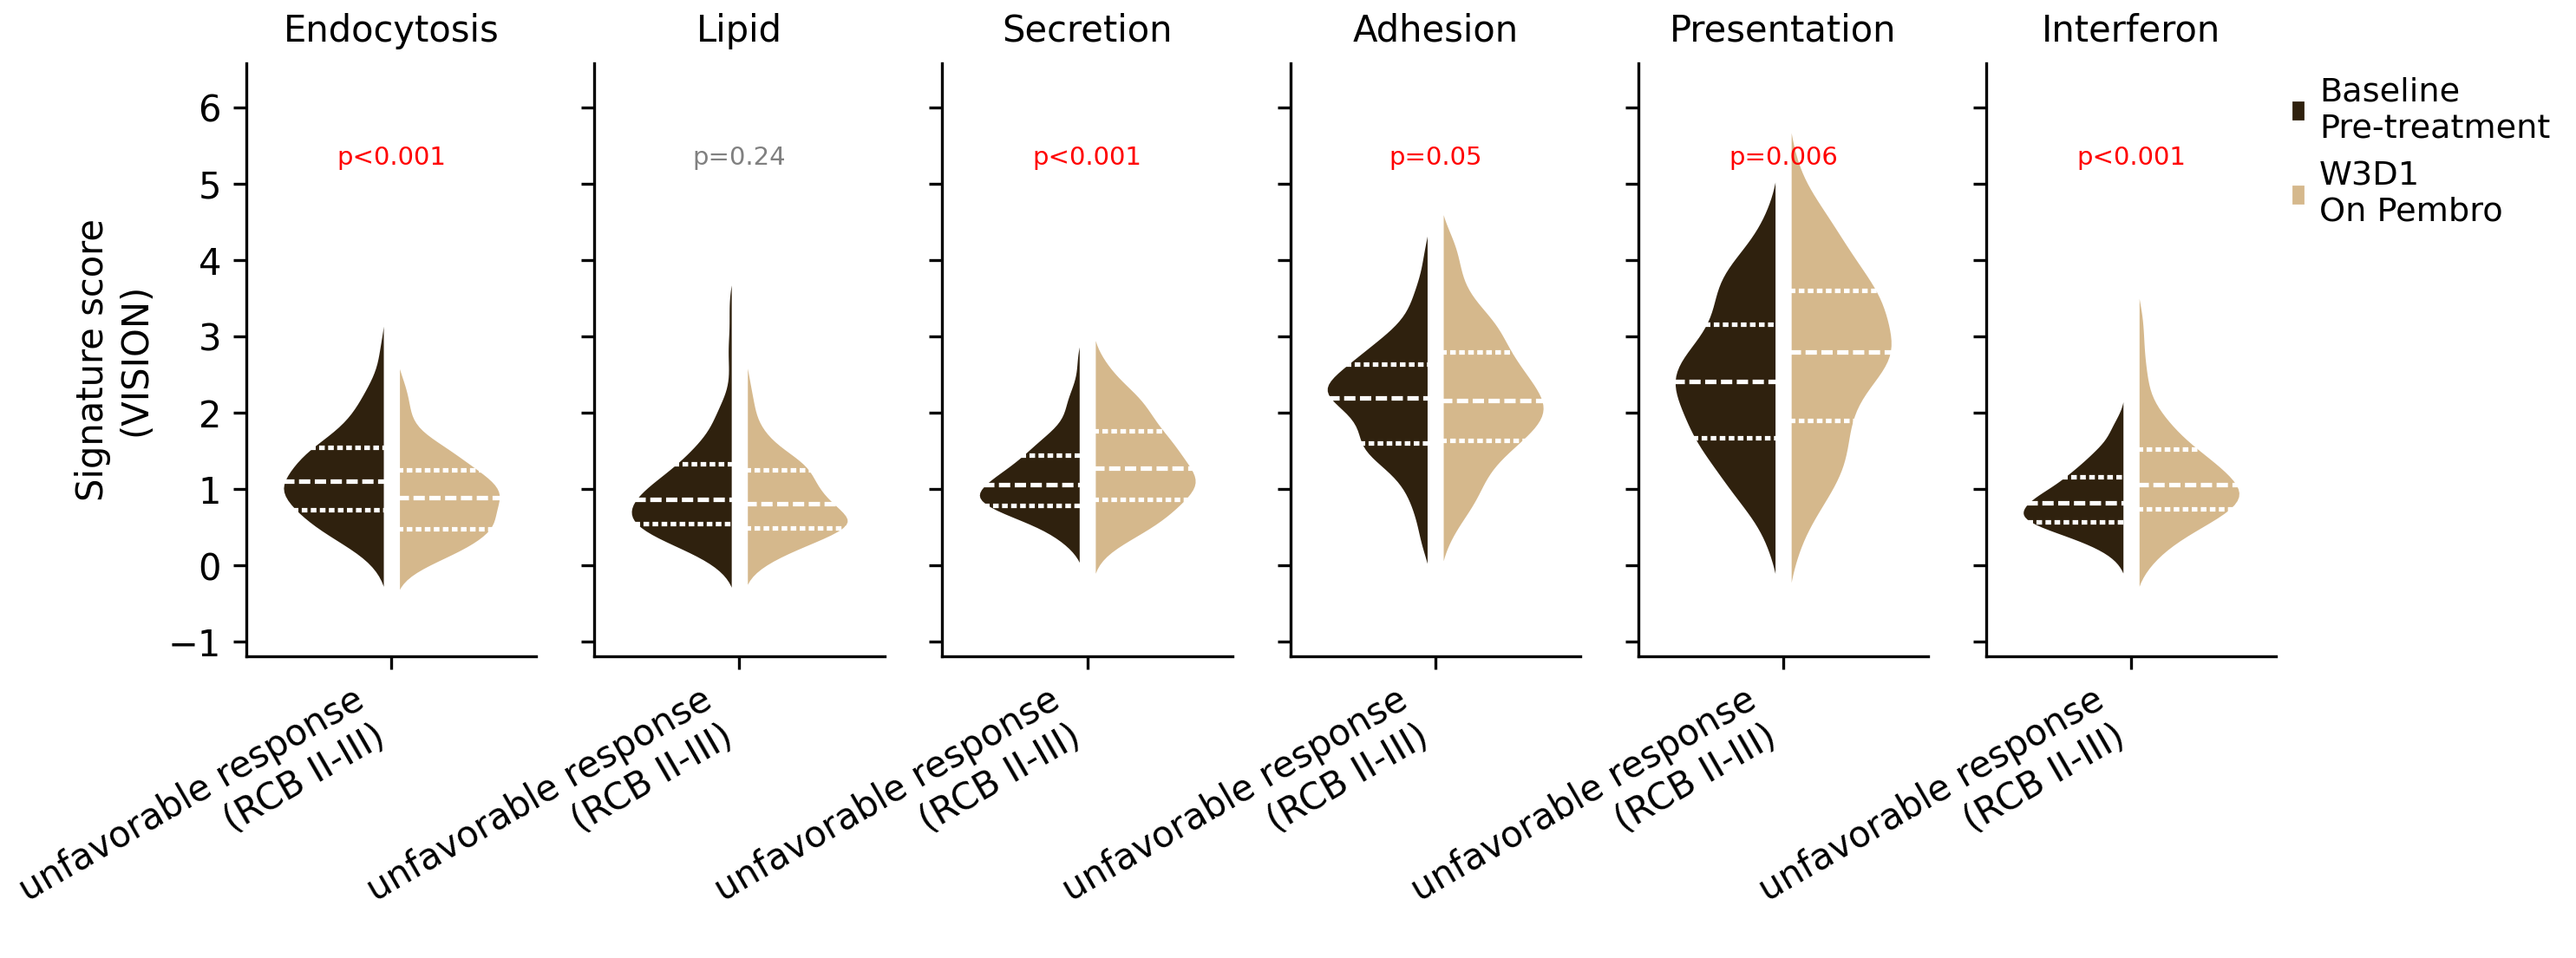

In [29]:
pvalues = result.set_index(['Y',explored_z])['Pvalue']
plt_dt = dt.rename(columns=MP_anno_map)
fig,axs=plt.subplots(1,6,dpi=150,sharey=True,figsize=(10,3))
for i,subtype in enumerate(show_mps):
    ax=axs[i]
    sns.violinplot(data=plt_dt,
                  x='BestResponse',y=subtype,hue='Timepoint',
                  ax=ax,
                  split=True, gap=.1, inner="quart",linecolor='white',
                  palette=COLOR_PAlETTE['Timepoint'])

    ## Add pvalue
    y_loc =5.5
    for xtick in ax.get_xticklabels():
        x_loc,_ = xtick.get_position()
        text = xtick.get_text()
        if pvalues[subtype,text] >= 0.05:
            c='gray'
            label = f"p={pvalues[subtype,text]:.2f}"
        elif pvalues[subtype,text] >= 0.01:
            label = f"p={pvalues[subtype,text]:.2f}"
            c = 'red'
        elif pvalues[subtype,text] >= 0.001:
            label = f"p={pvalues[subtype,text]:.3f}"
            c = 'red'
        else:
            label = "p<0.001"
            c = 'red'
        ax.text(x_loc,y_loc,s=label,ha='center',va='top',color=c,fontsize=7)
    ### rename legend label
    if i !=5:
        ax.legend_.remove()
    else:
        handles, previous_labels = ax.get_legend_handles_labels()
        new_labels = [ {'Baseline':'Baseline\nPre-treatment',
                        'W3D1':'W3D1\nOn Pembro'}[text]for text in previous_labels]
        ax.legend(loc=(1,.7),handles=handles, labels=new_labels)
    ax.set(xlabel='',title=subtype,ylabel='Signature score\n(VISION)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

## Combination induced MPs shifts

In [30]:
x='Timepoint'
explored_z='BestResponse'
random_var='Patient'
dt = scores.loc[(scores.Timepoint.isin(['W3D1','W7D1'])),:].copy()
## subsets pts with samples biopsied at both timepoint
paired_pts = dt[['Timepoint',random_var]].drop_duplicates()[random_var].value_counts()
paired_pts = paired_pts[paired_pts>1].index
dt= dt.loc[dt[random_var].isin(paired_pts),:]
## perform linear mixture model test
dt[x] = pd.Categorical(dt[x],['W3D1','W7D1'],ordered=True)
print(dt.groupby(explored_z)[random_var].nunique())
result = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[],explored_z=explored_z,random_var=random_var)
result.Y =  result.Y.map(MP_anno_map)
result

BestResponse
favorable response\n(RCB 0-I)         2
unfavorable response\n(RCB II-III)    3
Name: Patient, dtype: int64


,Ctrl,Experiment,Y,Coef,log2FC,Pvalue,BestResponse,FDR
0,W3D1,W7D1,Adhesion,-0.36724,-0.401676,6.759068184633492e-70,favorable response\n(RCB 0-I)+unfavorable resp...,0.0
0,W3D1,W7D1,Interferon,-0.192707,-0.3354,2.708884509224916e-12,favorable response\n(RCB 0-I)+unfavorable resp...,0.0
0,W3D1,W7D1,Adhesion,-0.624889,-0.273008,3.5463652756123165e-38,unfavorable response\n(RCB II-III),0.0
0,W3D1,W7D1,Adhesion,-0.271218,-0.273008,2.221352676306014e-32,favorable response\n(RCB 0-I),0.0
0,W3D1,W7D1,Secretion,-0.289005,-0.179905,3.153471099946609e-13,unfavorable response\n(RCB II-III),0.0
0,W3D1,W7D1,Secretion,-0.075918,-0.179905,0.0008263803620552346,favorable response\n(RCB 0-I),0.000992
0,W3D1,W7D1,Interferon,-0.212432,-0.178867,5.845918791603261e-06,unfavorable response\n(RCB II-III),0.000012
0,W3D1,W7D1,Interferon,-0.186187,-0.178867,2.591420510123088e-08,favorable response\n(RCB 0-I),0.0
0,W3D1,W7D1,Secretion,-0.133367,-0.17539,1.2779952940662456e-11,favorable response\n(RCB 0-I)+unfavorable resp...,0.0
0,W3D1,W7D1,Presentation,-0.079835,-0.013349,0.022535851147527916,favorable response\n(RCB 0-I)+unfavorable resp...,0.022536


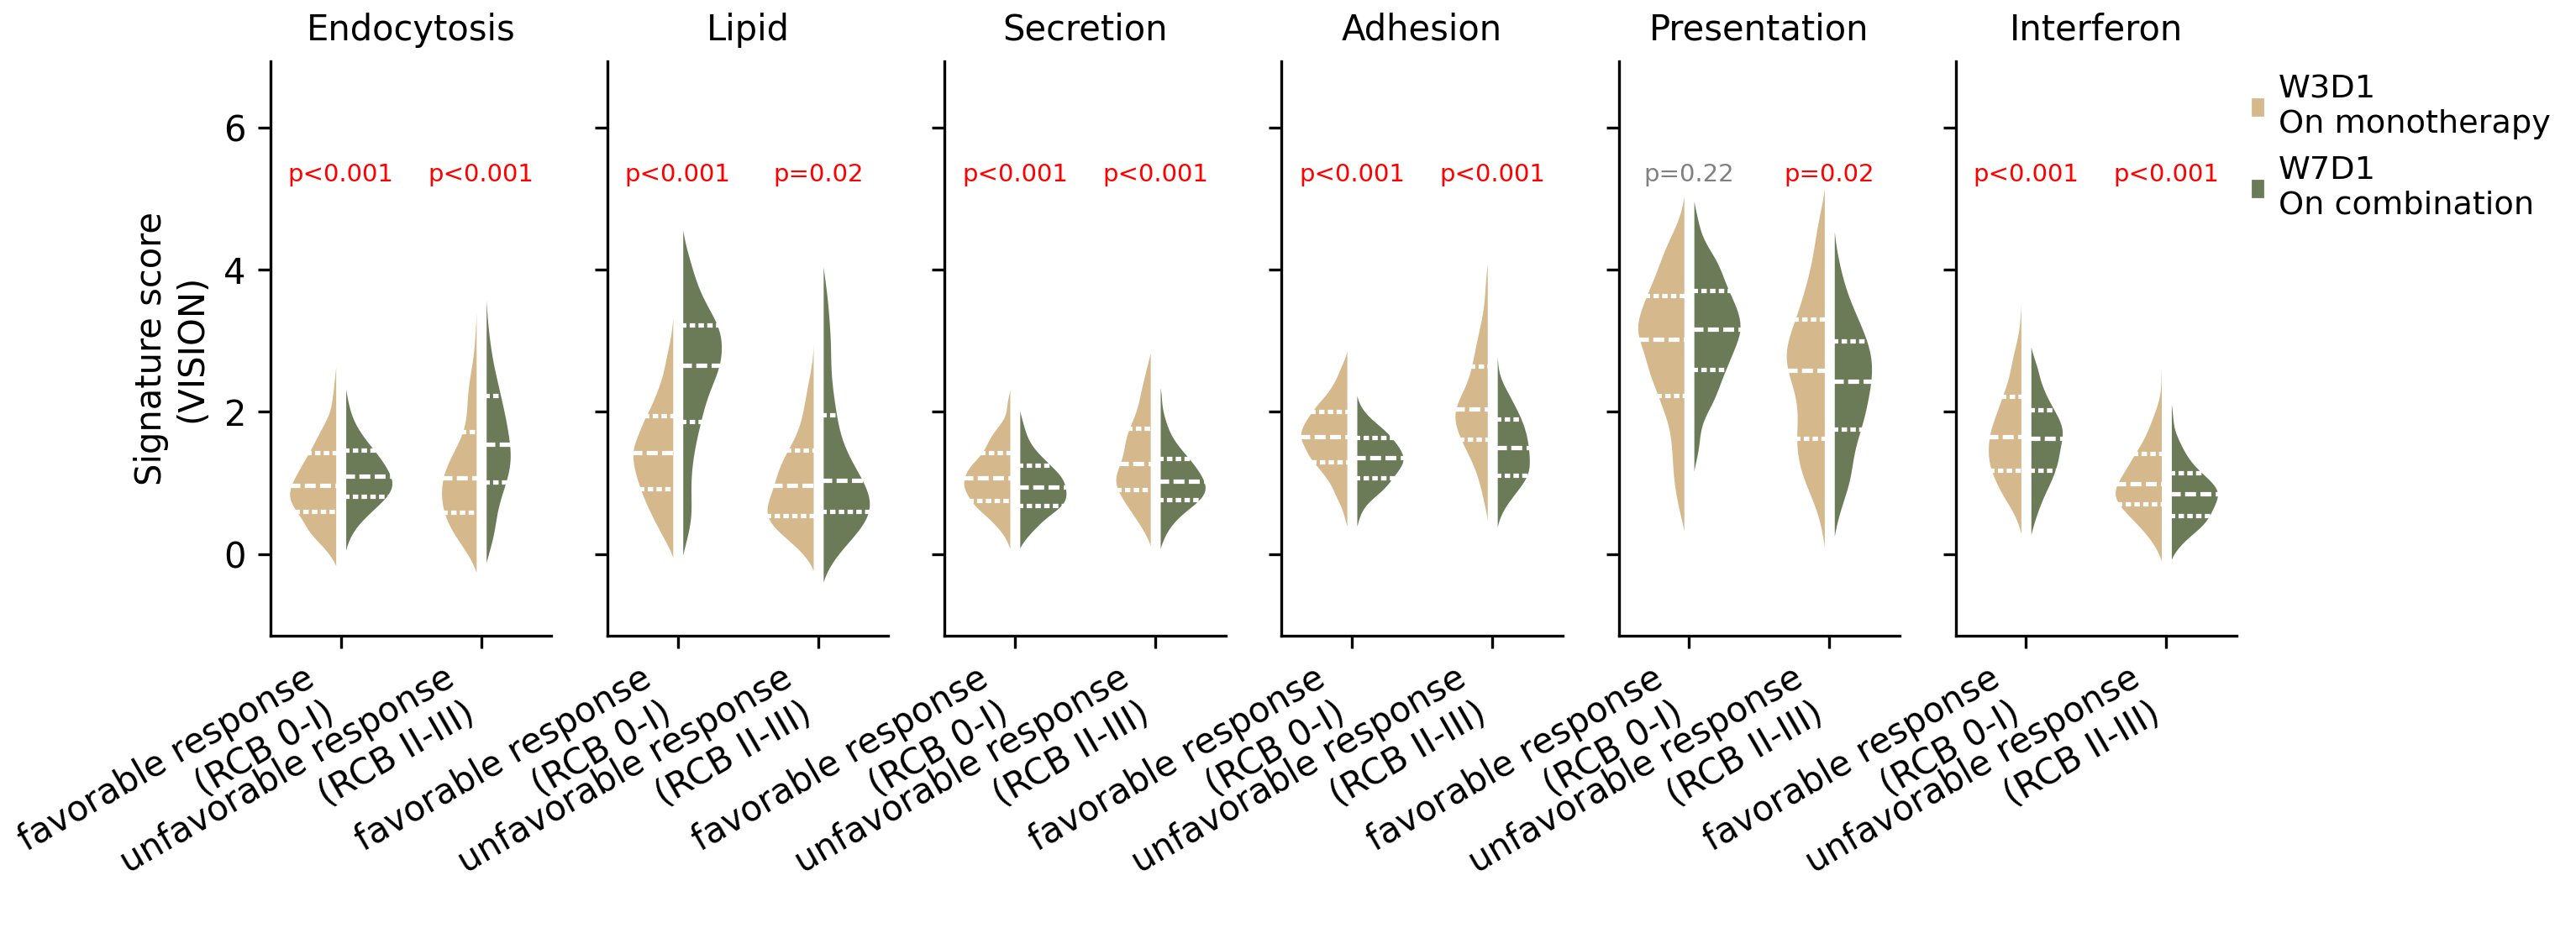

In [31]:
pvalues = result.set_index(['Y',explored_z])['Pvalue']
plt_dt = dt.rename(columns=MP_anno_map)
fig,axs=plt.subplots(1,6,dpi=150,sharey=True,figsize=(10,3))
for i,subtype in enumerate(show_mps):
    ax=axs[i]
    sns.violinplot(data=plt_dt,
                  x='BestResponse',y=subtype,hue='Timepoint',
                  ax=ax,
                  split=True, gap=.1, inner="quart",linecolor='white',
                  palette=COLOR_PAlETTE['Timepoint'])

    ## Add pvalue
    y_loc =5.5
    for xtick in ax.get_xticklabels():
        x_loc,_ = xtick.get_position()
        text = xtick.get_text()
        if pvalues[subtype,text] >= 0.05:
            c='gray'
            label = f"p={pvalues[subtype,text]:.2f}"
        elif pvalues[subtype,text] >= 0.01:
            label = f"p={pvalues[subtype,text]:.2f}"
            c = 'red'
        elif pvalues[subtype,text] >= 0.001:
            label = f"p={pvalues[subtype,text]:.3f}"
            c = 'red'
        else:
            label = "p<0.001"
            c = 'red'
        ax.text(x_loc,y_loc,s=label,ha='center',va='top',color=c,fontsize=7)
    ### rename legend label
    if i !=5:
        ax.legend_.remove()
    else:
        handles, previous_labels = ax.get_legend_handles_labels()
        new_labels = [ {'W7D1':'W7D1\nOn combination',
                        'W3D1':'W3D1\nOn monotherapy'}[text]for text in previous_labels]
        ax.legend(loc=(1,.7),handles=handles, labels=new_labels)
    ax.set(xlabel='',title=subtype,ylabel='Signature score\n(VISION)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

## Combination + AC

In [32]:
x='Timepoint'
explored_z='BestResponse'
random_var='Patient'
dt = scores.loc[(scores.Timepoint.isin(['W7D1','Pre-surgery'])),:].copy()
## subsets pts with samples biopsied at both timepoint
paired_pts = dt[['Timepoint',random_var]].drop_duplicates()[random_var].value_counts()
paired_pts = paired_pts[paired_pts>1].index
dt= dt.loc[dt[random_var].isin(paired_pts),:]
## perform linear mixture model test
dt[x] = pd.Categorical(dt[x],['W7D1','Pre-surgery'],ordered=True)
print(dt.groupby(explored_z)[random_var].nunique())
result = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[],explored_z=explored_z,random_var=random_var)
result.Y =  result.Y.map(MP_anno_map)
result

BestResponse
favorable response\n(RCB 0-I)         1
unfavorable response\n(RCB II-III)    1
Name: Patient, dtype: int64


,Ctrl,Experiment,Y,Coef,log2FC,Pvalue,BestResponse,FDR
0,W7D1,Pre-surgery,Presentation,-1.199922,-0.909684,4.319990958160909e-62,unfavorable response\n(RCB II-III),0.0
0,W7D1,Pre-surgery,Presentation,0.111829,-0.909684,0.6083779120287593,favorable response\n(RCB 0-I),0.730053
0,W7D1,Pre-surgery,Presentation,-1.048113,-0.468025,3.879420067923936e-49,unfavorable response\n(RCB II-III)+favorable r...,0.0
0,W7D1,Pre-surgery,Interferon,-0.156461,-0.369266,0.2232905618420123,favorable response\n(RCB 0-I),0.334936
0,W7D1,Pre-surgery,Interferon,-0.205296,-0.369266,5.4843643721281015e-05,unfavorable response\n(RCB II-III),0.000066
0,W7D1,Pre-surgery,Endocytosis,0.315458,-0.276096,0.00033952891410947954,unfavorable response\n(RCB II-III)+favorable r...,0.000461
0,W7D1,Pre-surgery,Interferon,-0.199644,-0.263049,2.4872160187549936e-05,unfavorable response\n(RCB II-III)+favorable r...,0.00005
0,W7D1,Pre-surgery,Lipid,-0.024586,-0.213747,0.5714599729733968,unfavorable response\n(RCB II-III)+favorable r...,0.57146
0,W7D1,Pre-surgery,Lipid,-0.00037,-0.044471,0.9937271033640755,unfavorable response\n(RCB II-III),0.993727
0,W7D1,Pre-surgery,Lipid,-0.209613,-0.044471,0.04435810736541871,favorable response\n(RCB 0-I),0.100047


In [33]:
dt.groupby([explored_z])['AC_Treatment'].unique()

BestResponse
favorable response\n(RCB 0-I)         [Yes]
unfavorable response\n(RCB II-III)    [Yes]
Name: AC_Treatment, dtype: object

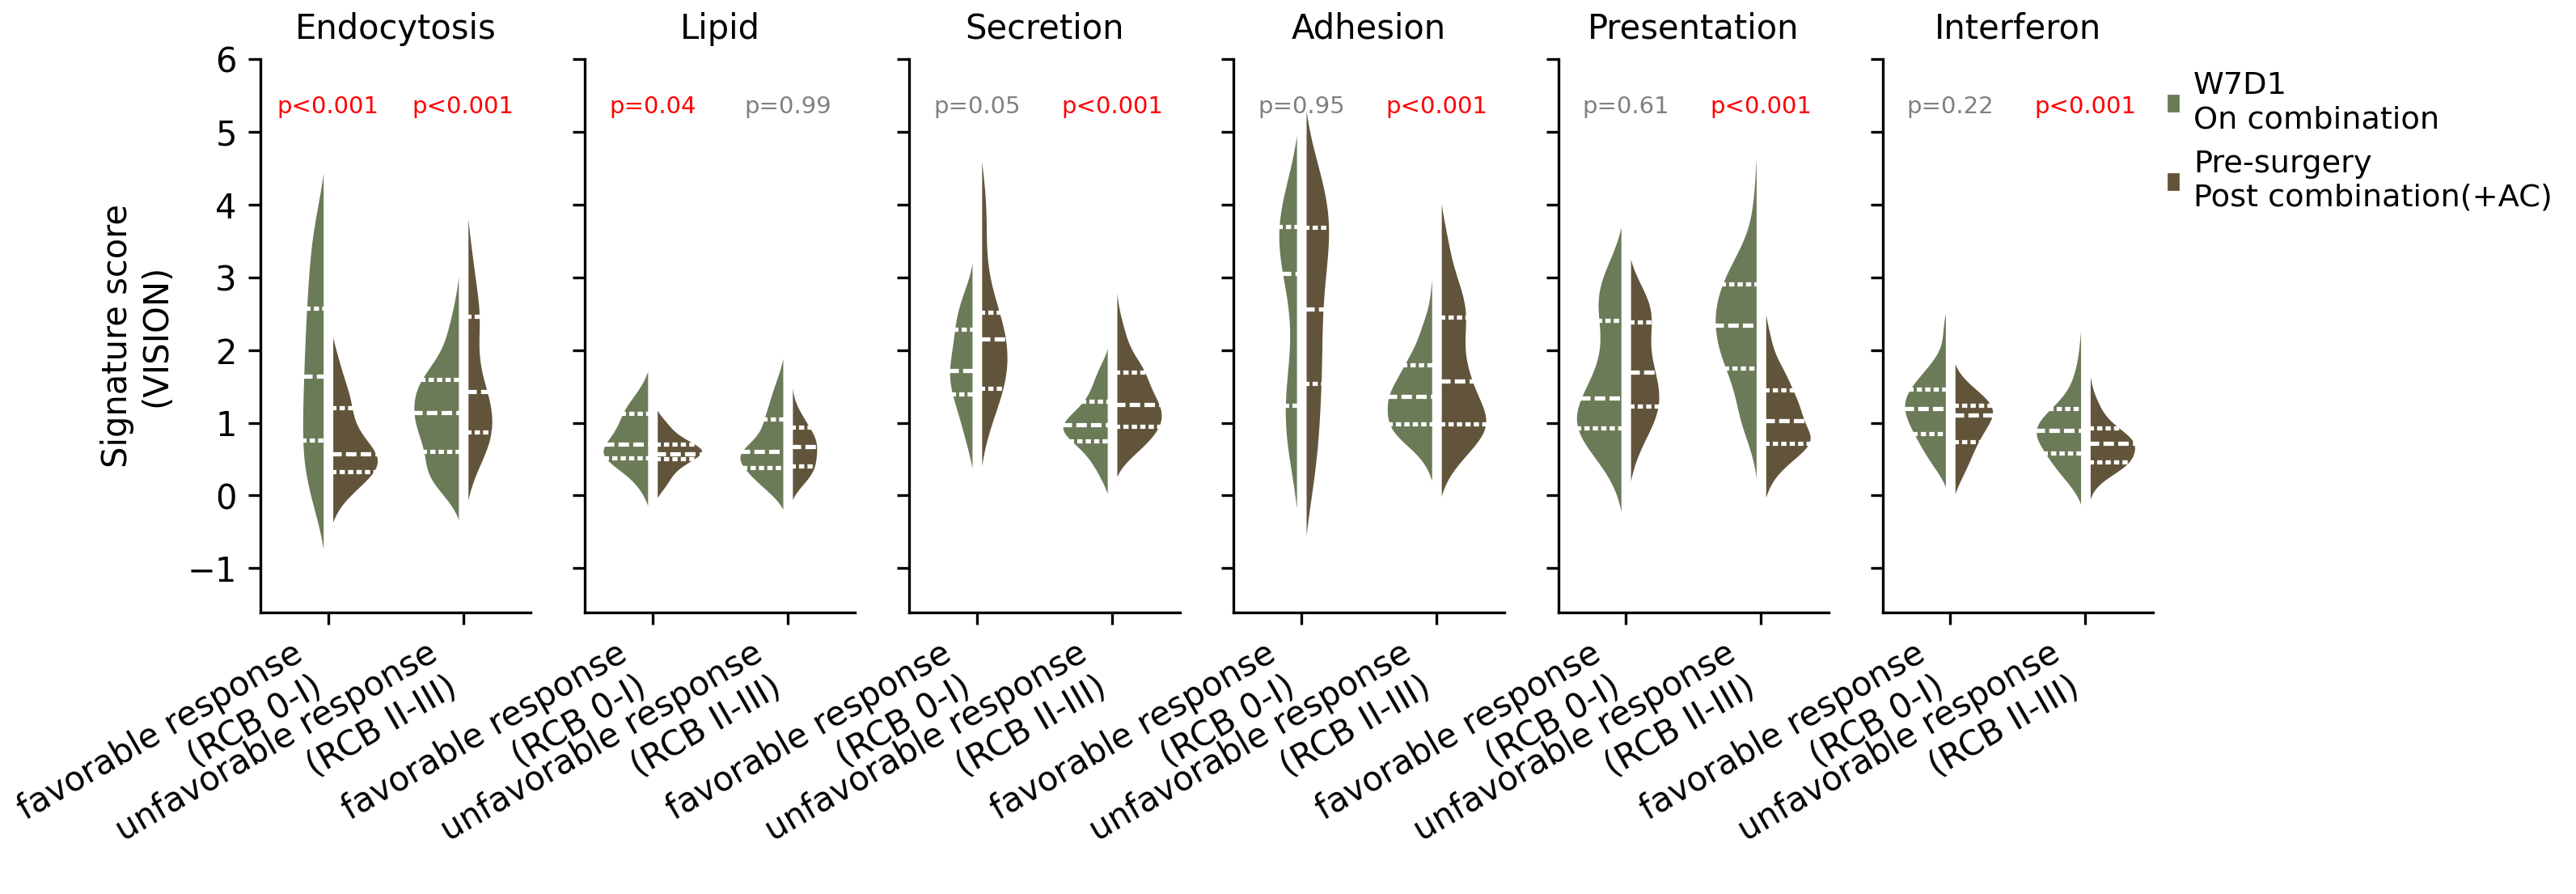

In [34]:
pvalues = result.set_index(['Y',explored_z])['Pvalue']
plt_dt = dt.rename(columns=MP_anno_map)
fig,axs=plt.subplots(1,6,dpi=150,sharey=True,figsize=(10,3))
for i,subtype in enumerate(show_mps):
    ax=axs[i]
    sns.violinplot(data=plt_dt,
                  x='BestResponse',y=subtype,hue='Timepoint',
                  ax=ax,
                  split=True, gap=.1, inner="quart",linecolor='white',
                  palette=COLOR_PAlETTE['Timepoint'])

    ## Add pvalue
    y_loc =5.5
    for xtick in ax.get_xticklabels():
        x_loc,_ = xtick.get_position()
        text = xtick.get_text()
        if pvalues[subtype,text] >= 0.05:
            c='gray'
            label = f"p={pvalues[subtype,text]:.2f}"
        elif pvalues[subtype,text] >= 0.01:
            label = f"p={pvalues[subtype,text]:.2f}"
            c = 'red'
        elif pvalues[subtype,text] >= 0.001:
            label = f"p={pvalues[subtype,text]:.3f}"
            c = 'red'
        else:
            label = "p<0.001"
            c = 'red'
        ax.text(x_loc,y_loc,s=label,ha='center',va='top',color=c,fontsize=7)
    ### rename legend label
    if i !=5:
        ax.legend_.remove()
    else:
        handles, previous_labels = ax.get_legend_handles_labels()
        new_labels = [ {'W7D1':'W7D1\nOn combination',
                        'Pre-surgery':'Pre-surgery\nPost combination(+AC)'}[text]for text in previous_labels]
        ax.legend(loc=(1,.7),handles=handles, labels=new_labels)
    ax.set(xlabel='',title=subtype,ylabel='Signature score\n(VISION)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

## On surgery - post treatment

In [35]:
x='Timepoint'
explored_z='BestResponse'
random_var='Patient'
dt = scores.loc[(scores.Timepoint.isin(['W7D1','Surgery'])),:].copy()
## subsets pts with samples biopsied at both timepoint
paired_pts = dt[['Timepoint',random_var]].drop_duplicates()[random_var].value_counts()
paired_pts = paired_pts[paired_pts>1].index
dt= dt.loc[dt[random_var].isin(paired_pts),:]
## perform linear mixture model test
dt[x] = pd.Categorical(dt[x],['W7D1','Surgery'],ordered=True)
print(dt.groupby(explored_z)[random_var].nunique())
dt[explored_z] = dt[explored_z].astype(str)
result = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[],explored_z=explored_z,random_var=random_var).drop_duplicates(['Y','BestResponse'])
result.Y =  result.Y.map(MP_anno_map)
result

BestResponse
favorable response\n(RCB 0-I)         1
unfavorable response\n(RCB II-III)    0
Name: Patient, dtype: int64


,Ctrl,Experiment,Y,Coef,log2FC,Pvalue,BestResponse,FDR
0,W7D1,Surgery,Endocytosis,-0.443148,-0.257522,0.048945747884610126,favorable response\n(RCB 0-I),0.073419
0,W7D1,Surgery,Interferon,-0.023863,-0.032034,0.787604612813229,favorable response\n(RCB 0-I),0.787605
0,W7D1,Surgery,Secretion,0.091328,0.084062,0.44509952530464003,favorable response\n(RCB 0-I),0.534119
0,W7D1,Surgery,Presentation,0.619551,0.481646,6.775116621293245e-07,favorable response\n(RCB 0-I),0.000001
0,W7D1,Surgery,Lipid,0.543001,0.725526,9.85528908013409e-14,favorable response\n(RCB 0-I),0.0
0,W7D1,Surgery,Adhesion,2.030913,1.345312,1.5854240581499392e-43,favorable response\n(RCB 0-I),0.0


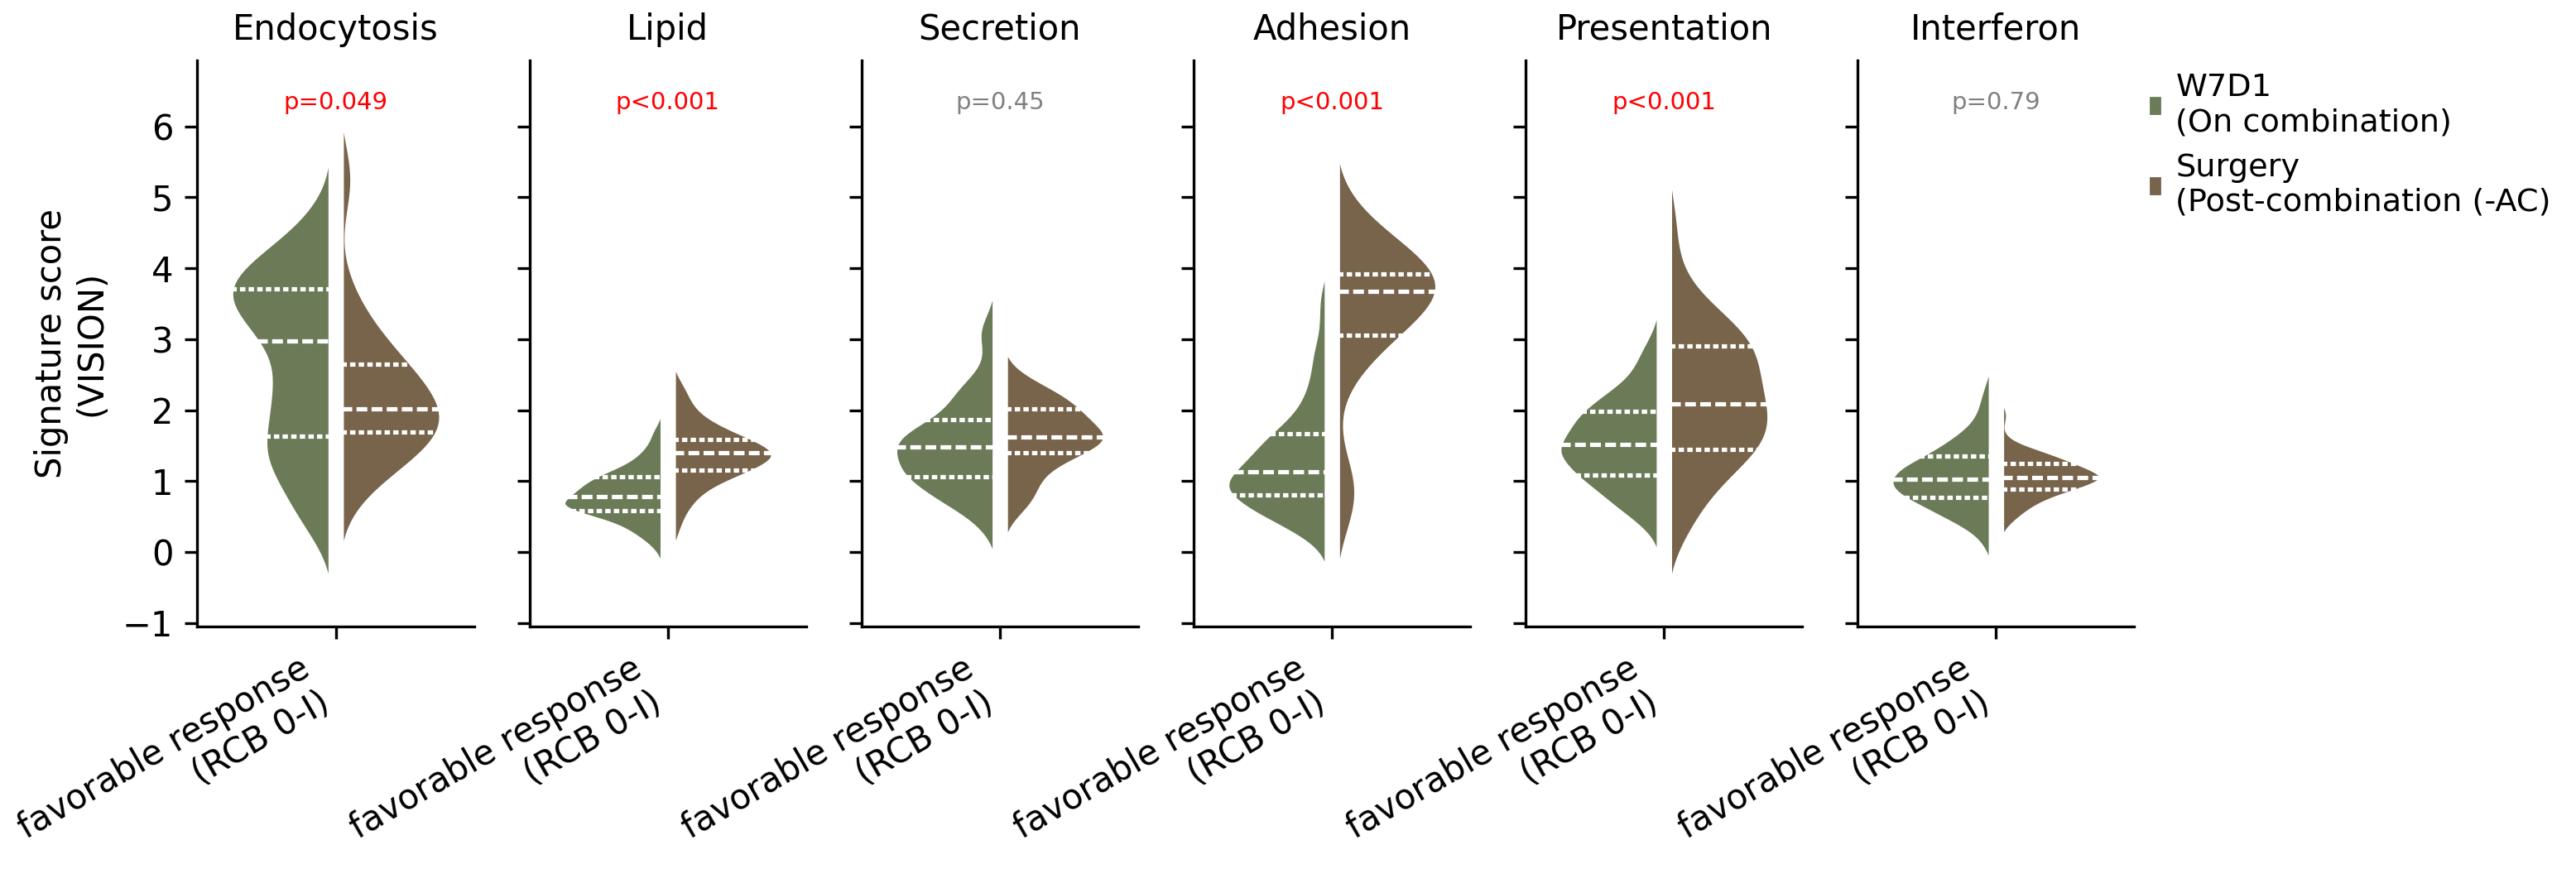

In [36]:
pvalues = result.set_index(['Y',explored_z])['Pvalue']
plt_dt = dt.rename(columns=MP_anno_map)
fig,axs=plt.subplots(1,6,dpi=150,sharey=True,figsize=(10,3))
for i,subtype in enumerate(show_mps):
    ax=axs[i]
    sns.violinplot(data=plt_dt,
                  x='BestResponse',y=subtype,hue='Timepoint',
                  ax=ax,
                  split=True, gap=.1, inner="quart",linecolor='white',
                  palette=COLOR_PAlETTE['Timepoint'])

    ## Add pvalue
    y_loc =6.5
    for xtick in ax.get_xticklabels():
        x_loc,_ = xtick.get_position()
        text = xtick.get_text()
        if pvalues[subtype,text] >= 0.05:
            c='gray'
            label = f"p={pvalues[subtype,text]:.2f}"
        elif pvalues[subtype,text] >= 0.01:
            label = f"p={pvalues[subtype,text]:.3f}"
            c = 'red'
        elif pvalues[subtype,text] >= 0.001:
            label = f"p={pvalues[subtype,text]:.3f}"
            c = 'red'
        else:
            label = "p<0.001"
            c = 'red'
        ax.text(x_loc,y_loc,s=label,ha='center',va='top',color=c,fontsize=7)
    ### rename legend label
    if i !=5:
        ax.legend_.remove()
    else:
        handles, previous_labels = ax.get_legend_handles_labels()
        new_labels = [ {'W7D1':'W7D1\n(On combination)',
                        'Surgery':'Surgery\n(Post-combination (-AC)'}[text]for text in previous_labels]
        ax.legend(loc=(1,.7),handles=handles, labels=new_labels)
    ax.set(xlabel='',title=subtype,ylabel='Signature score\n(VISION)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')